In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import re

from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

pd.options.display.float_format = '{:,.3f}'.format

print(os.listdir("../input"))

['ieee-fraud-detection']


In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load data

In [3]:
%%time
train_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_trn = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
test_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
test_trn = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')


CPU times: user 37.6 s, sys: 6.08 s, total: 43.7 s
Wall time: 58.3 s


In [4]:
train_id = reduce_mem_usage(train_id)
train_trn = reduce_mem_usage(train_trn)
test_id = reduce_mem_usage(test_id)
test_trn = reduce_mem_usage(test_trn)

Memory usage of dataframe is 45.12 MB --> 25.86 MB (Decreased by 42.7%)
Memory usage of dataframe is 1775.15 MB --> 542.35 MB (Decreased by 69.4%)
Memory usage of dataframe is 44.39 MB --> 25.44 MB (Decreased by 42.7%)
Memory usage of dataframe is 1519.24 MB --> 472.59 MB (Decreased by 68.9%)


In [5]:
print(train_id.shape, test_id.shape)
print(train_trn.shape, test_trn.shape)

(144233, 41) (141907, 41)
(590540, 394) (506691, 393)


# Data analysis

### what's target?

In [6]:
[c for c in train_trn.columns if c not in test_trn.columns]

['isFraud']

### isFraud

,0,1
isFraud,0.965,0.035


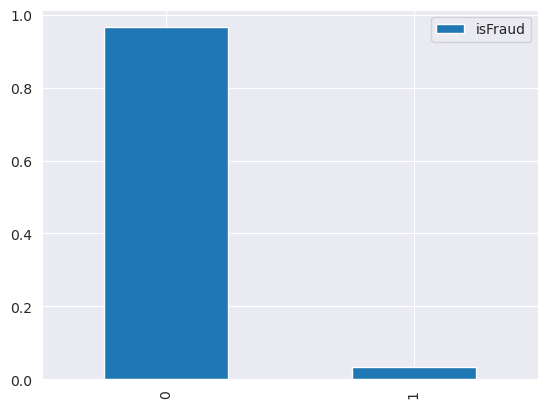

In [7]:
fc = train_trn['isFraud'].value_counts(normalize=True).to_frame()
fc.plot.bar()
fc.T

- fraud transaction rate by day, and week

<AxesSubplot:xlabel='_seq_week'>

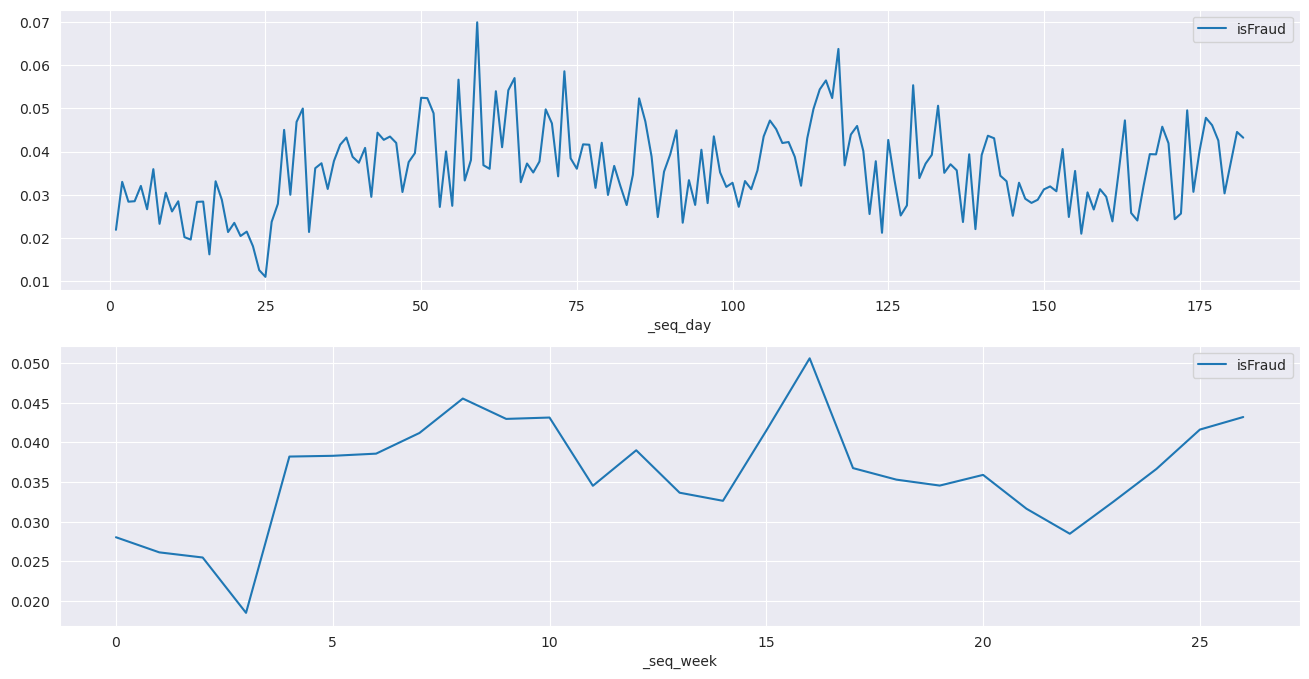

In [8]:
fig,ax = plt.subplots(2, 1, figsize=(16,8))

train_trn['_seq_day'] = train_trn['TransactionDT'] // (24*60*60)
train_trn['_seq_week'] = train_trn['_seq_day'] // 7
train_trn.groupby('_seq_day')['isFraud'].mean().to_frame().plot.line(ax=ax[0])
train_trn.groupby('_seq_week')['isFraud'].mean().to_frame().plot.line(ax=ax[1])

- fraud transaction rate by weekday, hour, month-day, and year-month

<AxesSubplot:xlabel='_year_month'>

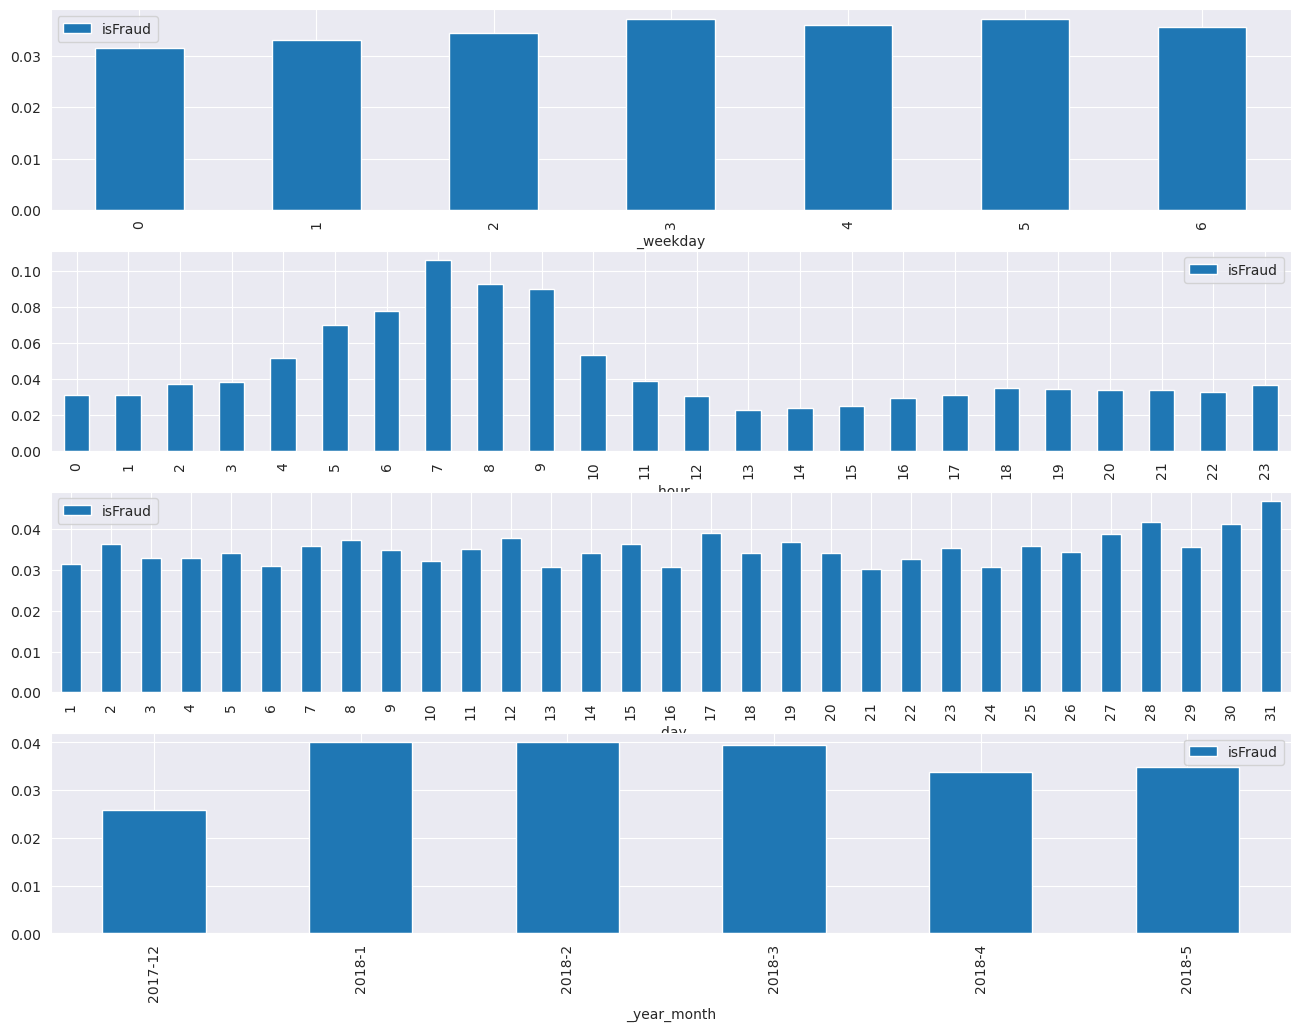

In [9]:
import datetime

START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train_trn['Date'] = train_trn['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train_trn['_ymd'] = train_trn['Date'].dt.year.astype(str) + '-' + train_trn['Date'].dt.month.astype(str) + '-' + train_trn['Date'].dt.day.astype(str)
train_trn['_year_month'] = train_trn['Date'].dt.year.astype(str) + '-' + train_trn['Date'].dt.month.astype(str)
train_trn['_weekday'] = train_trn['Date'].dt.dayofweek
train_trn['_hour'] = train_trn['Date'].dt.hour
train_trn['_day'] = train_trn['Date'].dt.day

fig,ax = plt.subplots(4, 1, figsize=(16,12))

train_trn.groupby('_weekday')['isFraud'].mean().to_frame().plot.bar(ax=ax[0])
train_trn.groupby('_hour')['isFraud'].mean().to_frame().plot.bar(ax=ax[1])
train_trn.groupby('_day')['isFraud'].mean().to_frame().plot.bar(ax=ax[2])
train_trn.groupby('_year_month')['isFraud'].mean().to_frame().plot.bar(ax=ax[3])

- fraud transaction rate by day

In [10]:
df = train_trn.groupby(['_ymd'])['isFraud'].agg(['count','mean','sum'])
df.sort_values(by='mean',ascending=False)[:10].T

_ymd,2018-1-28,2018-3-27,2018-2-11,2018-2-3,2018-1-25,2018-3-25,2018-4-8,2018-3-24,2018-2-2,2018-1-31
count,"2,402.000","3,042.000","2,304.000","3,209.000","2,789.000","2,461.000","2,348.000","2,758.000","4,317.000","3,057.000"
mean,0.070,0.064,0.059,0.057,0.057,0.056,0.055,0.054,0.054,0.054
sum,168.000,194.000,135.000,183.000,158.000,139.000,130.000,150.000,234.000,165.000


In [11]:
df.sort_values(by='count',ascending=False)[:10].T

_ymd,2017-12-22,2018-3-2,2017-12-24,2017-12-23,2017-12-20,2017-12-25,2017-12-21,2017-12-18,2017-12-19,2017-12-1
count,"6,852.000","6,252.000","6,065.000","5,872.000","5,749.000","5,742.000","5,677.000","5,585.000","5,526.000","5,122.000"
mean,0.021,0.024,0.013,0.018,0.023,0.011,0.020,0.029,0.021,0.022
sum,147.000,147.000,76.000,106.000,135.000,63.000,116.000,161.000,118.000,112.000


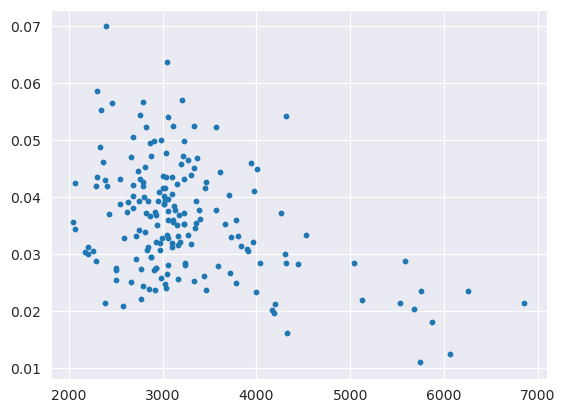

In [12]:
# transaction-count X fraud-rate
plt.scatter(df['count'], df['mean'], s=10)

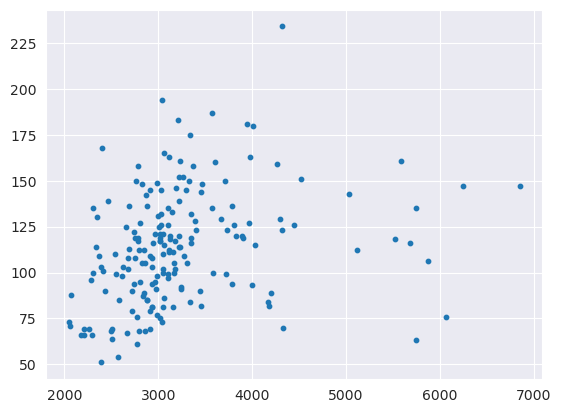

In [13]:
# transaction-count X fraud-count
plt.scatter(df['count'], df['sum'], s=10)

- fraud transaction rate by weekday-hour

<AxesSubplot:xlabel='_weekday_hour'>

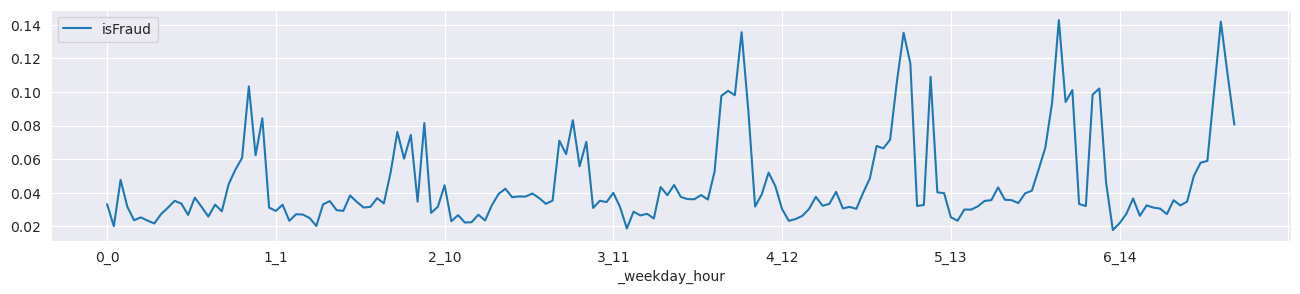

In [14]:
train_trn['_weekday_hour'] = train_trn['_weekday'].astype(str) + '_' + train_trn['_hour'].astype(str)
train_trn.groupby('_weekday_hour')['isFraud'].mean().to_frame().plot.line(figsize=(16,3))

- fraud rate by weekday 

In [15]:
df = train_trn.groupby('_weekday')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False)

,isFraud
_weekday,
3,0.037
5,0.037
4,0.036
6,0.036
2,0.035
1,0.033
0,0.031


- fraud rate by hour 

In [16]:
df = train_trn.groupby('_hour')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False).head(10)

,isFraud
_hour,
7,0.106
8,0.093
9,0.090
6,0.078
5,0.070
10,0.053
4,0.052
11,0.039
3,0.038


- fraud rate by weekday-hour

In [17]:
df = train_trn.groupby('_weekday_hour')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False).head(10)

,isFraud
_weekday_hour,
5_7,0.143
6_7,0.142
3_8,0.136
4_8,0.135
4_9,0.117
6_8,0.110
5_10,0.109
4_7,0.106
0_7,0.103


- fraud rate by amount-bin

In [18]:
train_trn['_amount_qcut10'] = pd.qcut(train_trn['TransactionAmt'],10)
df = train_trn.groupby('_amount_qcut10')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False)

,isFraud
_amount_qcut10,
"(0.25, 25.953]",0.056
"(275.25, 31936.0]",0.051
"(117.0, 160.0]",0.043
"(160.0, 275.25]",0.038
"(68.75, 100.0]",0.036
"(35.938, 49.0]",0.032
"(25.953, 35.938]",0.032
"(57.938, 68.75]",0.029
"(100.0, 117.0]",0.020


### TransactionID

In [19]:
# Not all transactions have corresponding identity information.
#len([c for c in train_trn['TransactionID'] if c not in train_id['TransactionID'].values]) #446307

# Not all fraud transactions have corresponding identity information.
fraud_id = train_trn[train_trn['isFraud'] == 1]['TransactionID']
fraud_id_in_trn = [i for i in fraud_id if i in train_id['TransactionID'].values]
print(f'fraud data count:{len(fraud_id)}, and in trn:{len(fraud_id_in_trn)}')

fraud data count:20663, and in trn:11318


## Identity data

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners. (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:

- DeviceType
- DeviceInfo
- id12 - id38

In [20]:
train_id_trn = pd.merge(train_id, train_trn[['isFraud','TransactionAmt','TransactionID']])
train_id_f0 = train_id_trn[train_id_trn['isFraud'] == 0]
train_id_f1 = train_id_trn[train_id_trn['isFraud'] == 1]
print(train_id_f0.shape, train_id_f1.shape)

def plotHistByFraud(col, bins=20, figsize=(8,3)):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=figsize)
        plt.hist([train_id_f0[col], train_id_f1[col]], bins=bins, density=True, color=['royalblue', 'orange'])
        
def plotCategoryRateBar(col, topN=np.nan, figsize=(8,3)):
    a, b = train_id_f0, train_id_f1
    if topN == topN: # isNotNan
        vals = b[col].value_counts(normalize=True).to_frame().iloc[:topN,0]
        subA = a.loc[a[col].isin(vals.index.values), col]
        df = pd.DataFrame({'normal':subA.value_counts(normalize=True), 'fraud':vals})
    else:
        df = pd.DataFrame({'normal':a[col].value_counts(normalize=True), 'fraud':b[col].value_counts(normalize=True)})
    df.sort_values('fraud', ascending=False).plot.bar(figsize=figsize)

(132915, 43) (11318, 43)


### id_01 - id_11

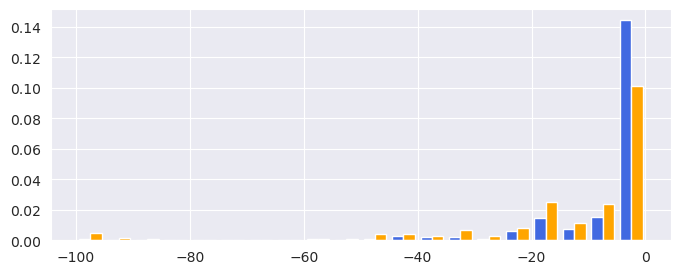

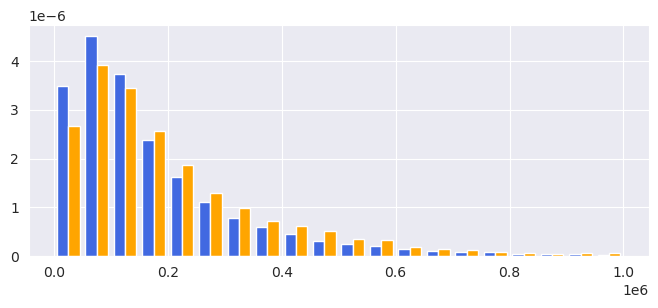

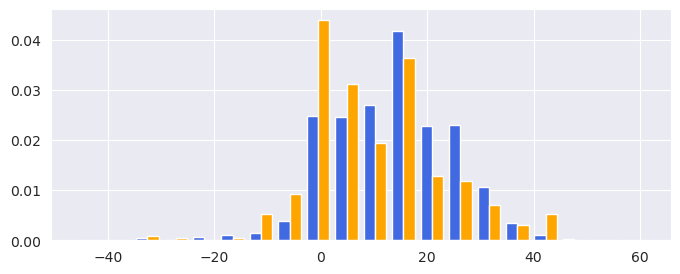

In [21]:
plotHistByFraud('id_01')
plotHistByFraud('id_02')
plotHistByFraud('id_07')

In [22]:
numid_cols = [f'id_{str(i).zfill(2)}' for i in range(1,12)]
train_id_trn[numid_cols].isna().sum().to_frame().T / len(train_id)

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
0,0.000,0.023,0.540,0.540,0.051,0.051,0.964,0.964,0.481,0.481,0.023


<AxesSubplot:>

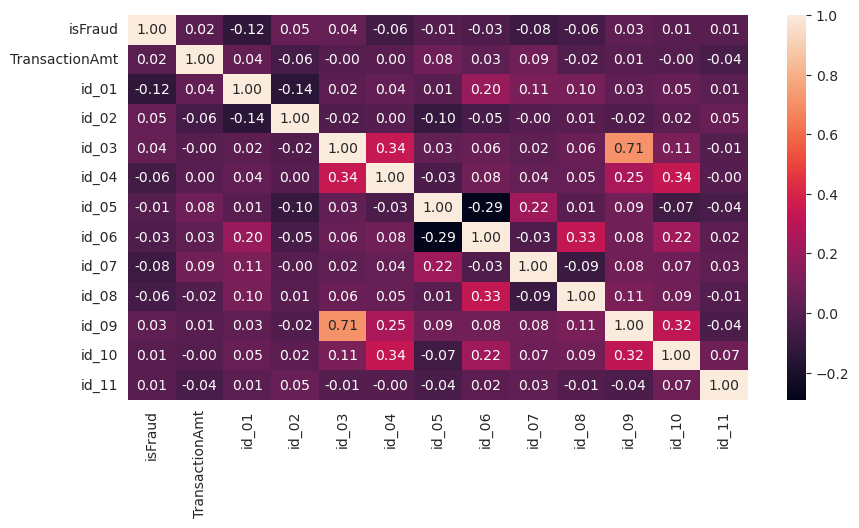

In [23]:
plt.figure(figsize=(10, 5))
sns.heatmap(train_id_trn[['isFraud','TransactionAmt']+numid_cols].corr(), annot=True, fmt='.2f')

In [24]:
train_id_f1[['isFraud'] + numid_cols].head(10)

,isFraud,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
52,1,0.000,"169,947.000",0.000,0.000,3.000,0.000,NaN,NaN,0.000,0.000,100.000
53,1,0.000,"222,455.000",0.000,0.000,0.000,0.000,NaN,NaN,0.000,0.000,100.000
54,1,0.000,"271,870.000",0.000,0.000,3.000,0.000,NaN,NaN,0.000,0.000,100.000
69,1,-20.000,"258,138.000",NaN,NaN,0.000,-1.000,NaN,NaN,NaN,NaN,100.000
86,1,-5.000,"141,271.000",NaN,NaN,9.000,-81.000,NaN,NaN,0.000,0.000,97.562
98,1,-20.000,"550,210.000",NaN,NaN,0.000,-1.000,NaN,NaN,NaN,NaN,100.000
185,1,-25.000,"59,967.000",NaN,NaN,1.000,-12.000,NaN,NaN,NaN,NaN,100.000
201,1,-5.000,"30,602.000",NaN,NaN,0.000,-12.000,NaN,NaN,0.000,0.000,95.062
235,1,-5.000,"4,235.000",NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,100.000
236,1,0.000,"36,004.000",0.000,0.000,0.000,0.000,NaN,NaN,0.000,0.000,100.000


In [25]:
train_id_f0[['isFraud'] + numid_cols].head(10)

,isFraud,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
0,0,0.000,"70,787.000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000
1,0,-5.000,"98,945.000",NaN,NaN,0.000,-5.000,NaN,NaN,NaN,NaN,100.000
2,0,-5.000,"191,631.000",0.000,0.000,0.000,0.000,NaN,NaN,0.000,0.000,100.000
3,0,-5.000,"221,832.000",NaN,NaN,0.000,-6.000,NaN,NaN,NaN,NaN,100.000
4,0,0.000,"7,460.000",0.000,0.000,1.000,0.000,NaN,NaN,0.000,0.000,100.000
5,0,-5.000,"61,141.000",3.000,0.000,3.000,0.000,NaN,NaN,3.000,0.000,100.000
6,0,-15.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,0.000,"31,964.000",0.000,0.000,0.000,-10.000,NaN,NaN,0.000,0.000,100.000
8,0,-10.000,"116,098.000",0.000,0.000,0.000,0.000,NaN,NaN,0.000,0.000,100.000
9,0,-5.000,"257,037.000",NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,100.000


### id_12 - id_38

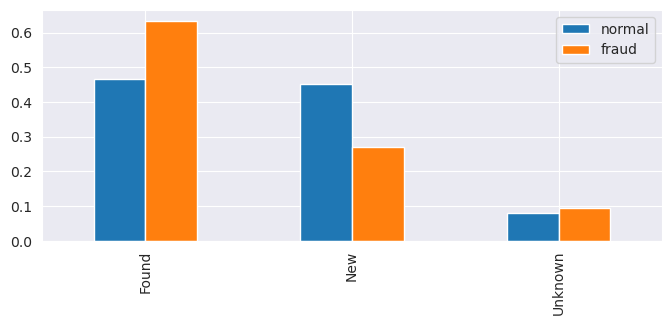

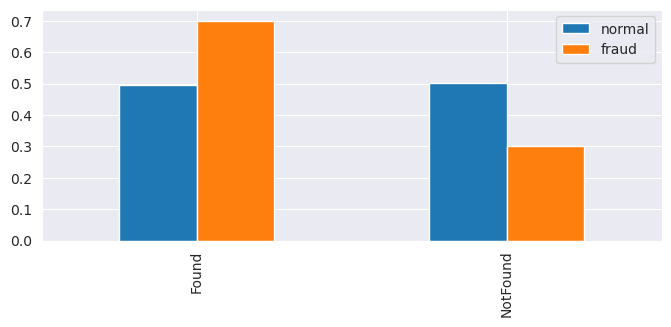

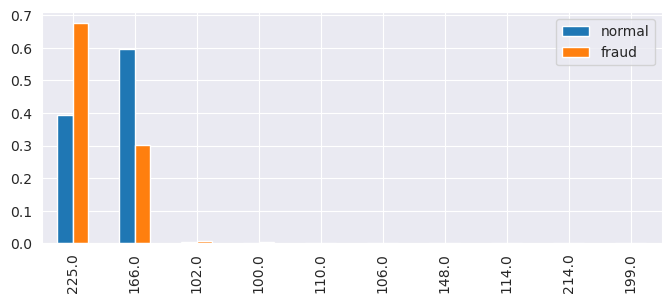

In [26]:
plotCategoryRateBar('id_15')
plotCategoryRateBar('id_16')
plotCategoryRateBar('id_17',10)

unique count: 522


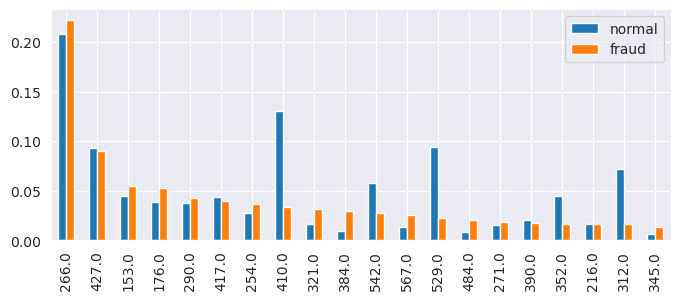

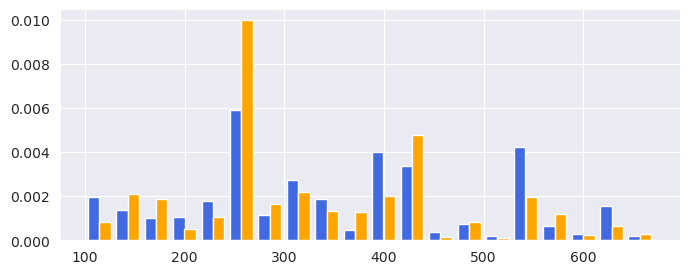

In [27]:
plotCategoryRateBar('id_19', 20)
plotHistByFraud('id_19')
print('unique count:', train_id['id_19'].nunique())

unique count: 394


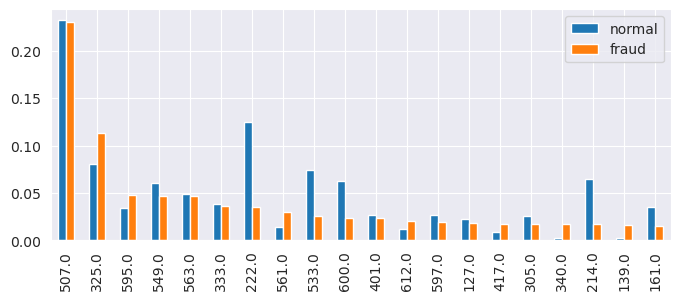

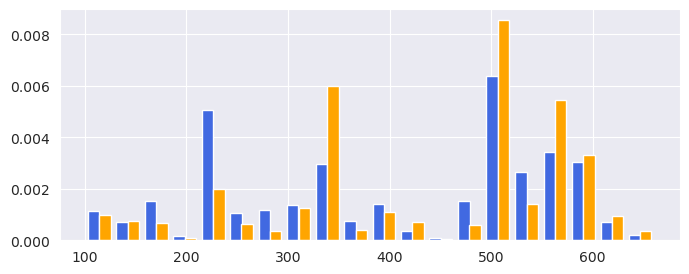

In [28]:
plotCategoryRateBar('id_20', 20)
plotHistByFraud('id_20')
print('unique count:', train_id['id_20'].nunique())

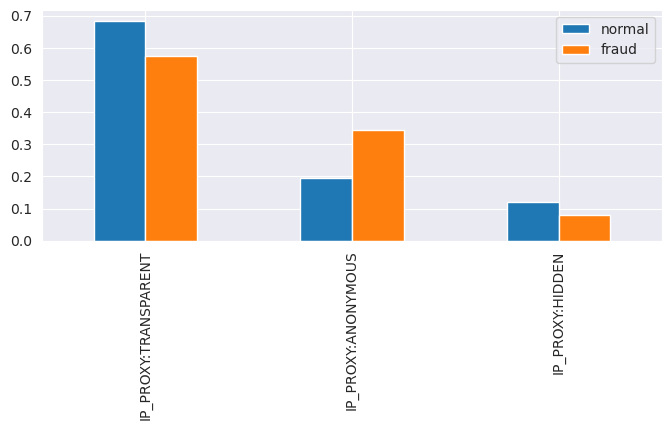

In [29]:
plotCategoryRateBar('id_23')

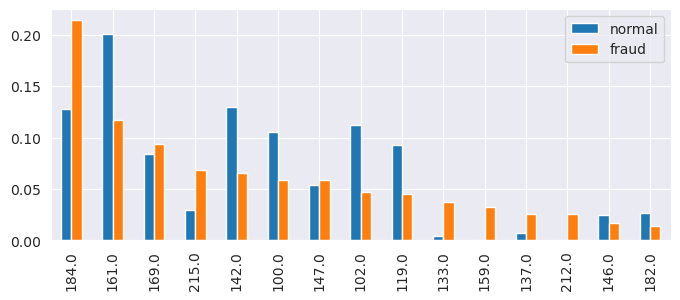

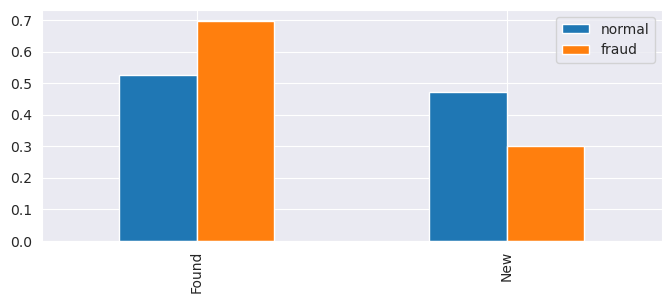

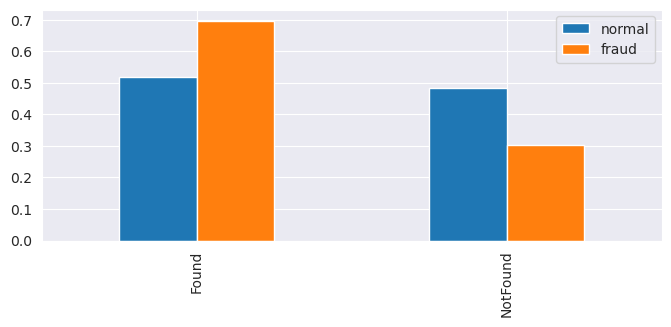

In [30]:
plotCategoryRateBar('id_26', 15)
plotCategoryRateBar('id_28')
plotCategoryRateBar('id_29')

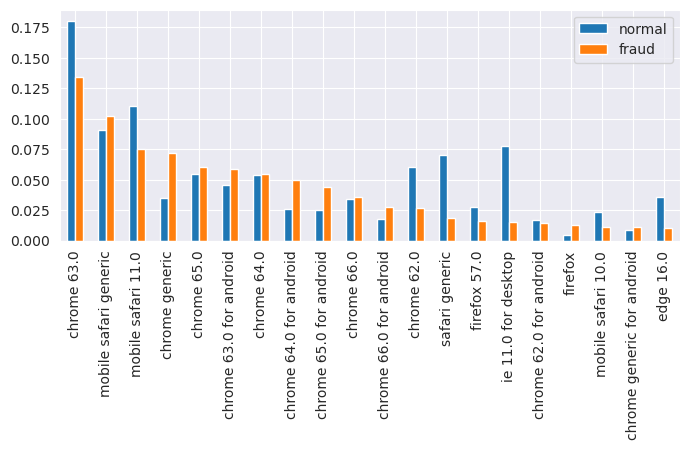

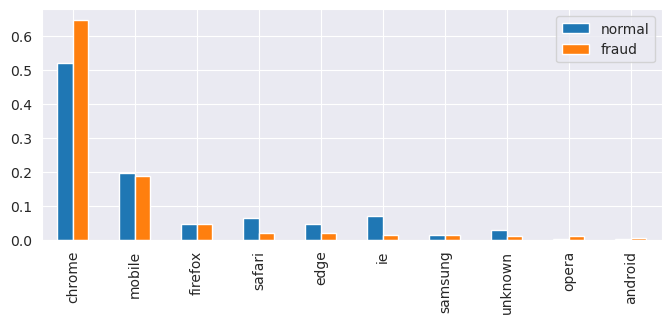

In [31]:
plotCategoryRateBar('id_31', 20)

train_id_f0['_id_31_ua'] = train_id_f0['id_31'].apply(lambda x: x.split()[0] if x == x else 'unknown')
train_id_f1['_id_31_ua'] = train_id_f1['id_31'].apply(lambda x: x.split()[0] if x == x else 'unknown')
plotCategoryRateBar('_id_31_ua', 10)

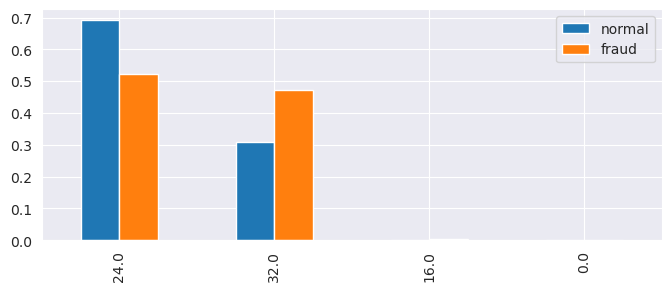

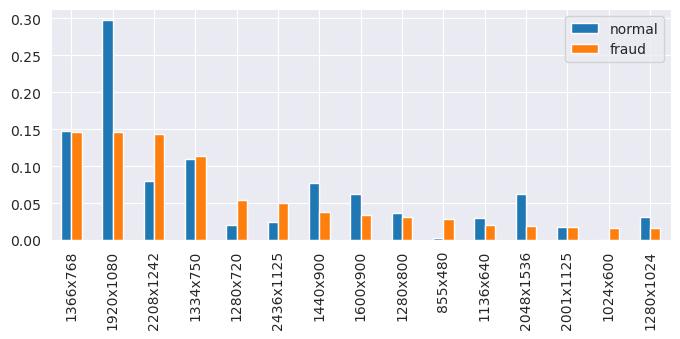

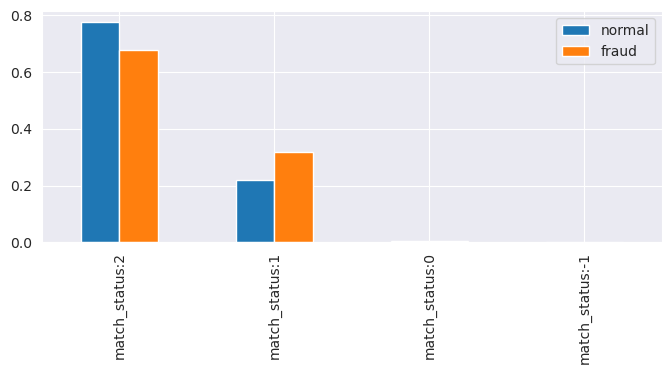

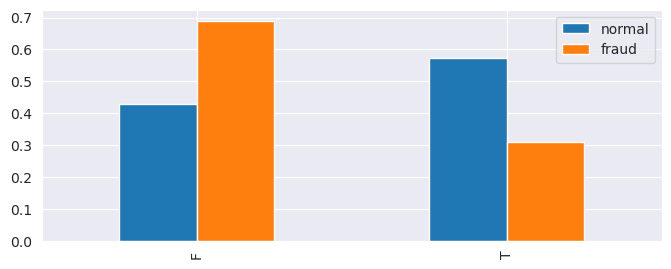

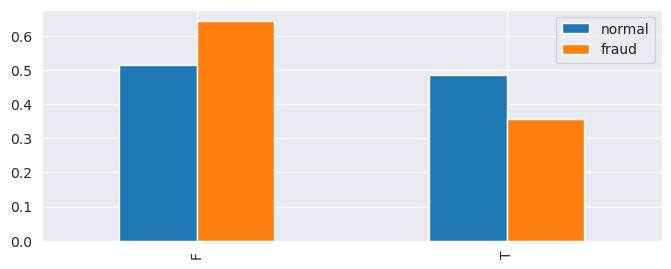

In [32]:
plotCategoryRateBar('id_32')
plotCategoryRateBar('id_33',15)
plotCategoryRateBar('id_34')
plotCategoryRateBar('id_35')
plotCategoryRateBar('id_38')

### DeviceType, DeviceInfo

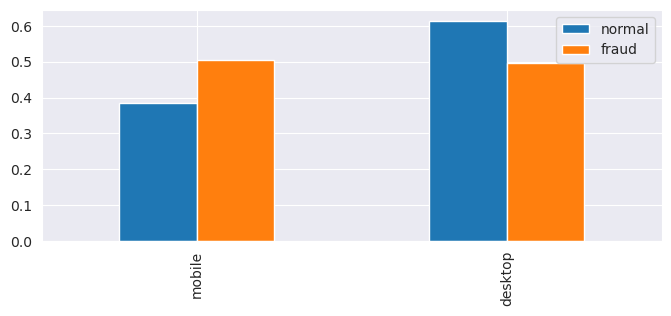

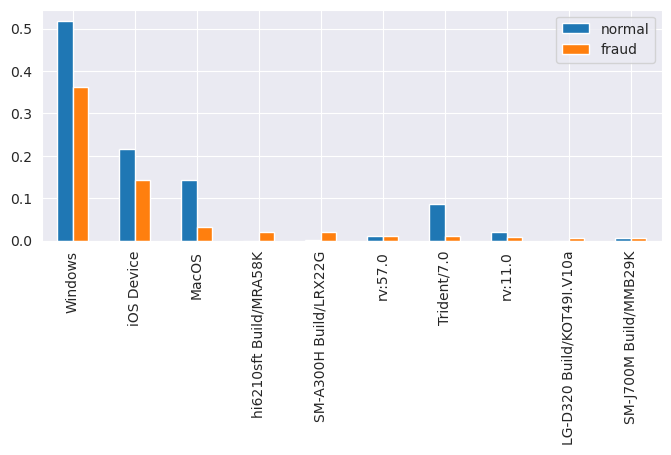

In [33]:
plotCategoryRateBar('DeviceType')
plotCategoryRateBar('DeviceInfo',10)

## Transaction data

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

In [34]:
ccols = [f'C{i}' for i in range(1,15)]
dcols = [f'D{i}' for i in range(1,16)]
mcols = [f'M{i}' for i in range(1,10)]
vcols = [f'V{i}' for i in range(1,340)]

In [35]:
train_trn_f0 = train_trn[train_trn['isFraud'] == 0]
train_trn_f1 = train_trn[train_trn['isFraud'] == 1]
print(train_trn_f0.shape, train_trn_f1.shape)

def plotTrnHistByFraud(col, bins=20, figsize=(8,3)):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=figsize)
        plt.hist([train_trn_f0[col], train_trn_f1[col]], bins=bins, density=True, color=['royalblue', 'orange'])

def plotTrnLogHistByFraud(col, bins=20, figsize=(8,3)):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=figsize)
        plt.hist([np.log1p(train_trn_f0[col]), np.log1p(train_trn_f1[col])], bins=bins, density=True, color=['royalblue', 'orange'])
        
def plotTrnCategoryRateBar(col, topN=np.nan, figsize=(8,3)):
    a, b = train_trn_f0, train_trn_f1
    if topN == topN: # isNotNan
        vals = b[col].value_counts(normalize=True).to_frame().iloc[:topN,0]
        subA = a.loc[a[col].isin(vals.index.values), col]
        df = pd.DataFrame({'normal':subA.value_counts(normalize=True), 'fraud':vals})
    else:
        df = pd.DataFrame({'normal':a[col].value_counts(normalize=True), 'fraud':b[col].value_counts(normalize=True)})
    df.sort_values('fraud', ascending=False).plot.bar(figsize=figsize)

(569877, 404) (20663, 404)


### TransactionDT

In [36]:
#START_DATE = '2017-11-30'
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

train_date = train_trn['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
test_date = test_trn['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

print('train date:', train_date.min(), '-', train_date.max())
print('test  date:', test_date.min(), '-', test_date.max())

train date: 2017-12-02 00:00:00 - 2018-06-01 23:58:51
test  date: 2018-07-02 00:00:24 - 2018-12-31 23:59:05


<AxesSubplot:>

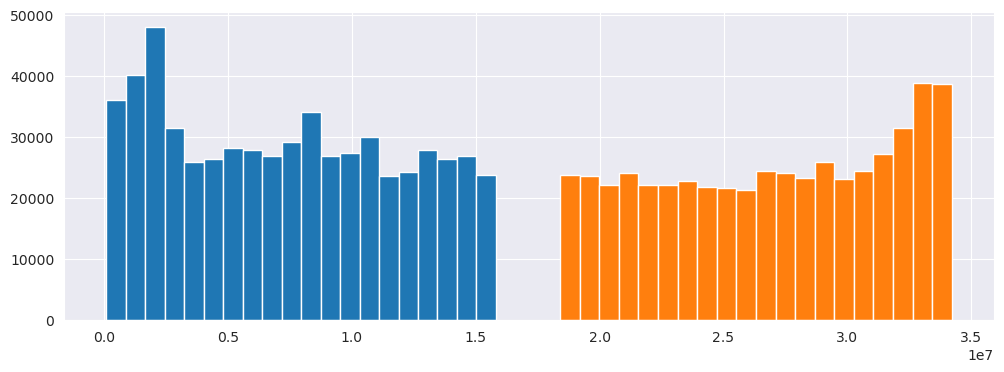

In [37]:
plt.figure(figsize=(12,4))
train_trn['TransactionDT'].hist(bins=20)
test_trn['TransactionDT'].hist(bins=20)

In [38]:
def appendLagDT(df):
    df = df.assign(_date_lag = df['TransactionDT'] - df.groupby(['card1','card2'])['TransactionDT'].shift(1))
    return df

train_trn = appendLagDT(train_trn)
train_trn_f0 = train_trn[train_trn['isFraud'] == 0]
train_trn_f1 = train_trn[train_trn['isFraud'] == 1]

In [39]:
pd.concat([train_trn_f0['_date_lag'].describe(), 
           train_trn_f1['_date_lag'].describe()], axis=1)

,_date_lag,_date_lag
count,"548,219.000","19,898.000"
mean,"171,647.294","122,550.929"
std,"707,372.753","649,306.365"
min,0.000,0.000
25%,"1,004.000",423.000
50%,"6,010.000","3,511.000"
75%,"59,342.000","29,619.500"
max,"15,599,674.000","14,447,608.000"


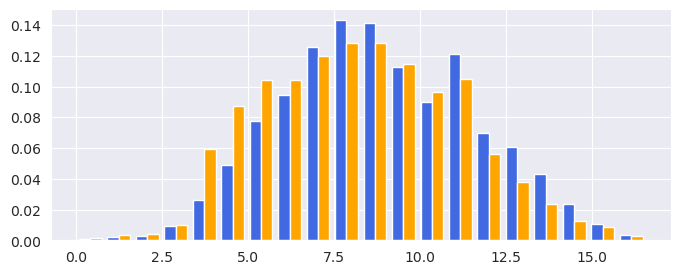

In [40]:
plotTrnLogHistByFraud('_date_lag')

### TransactionAmt

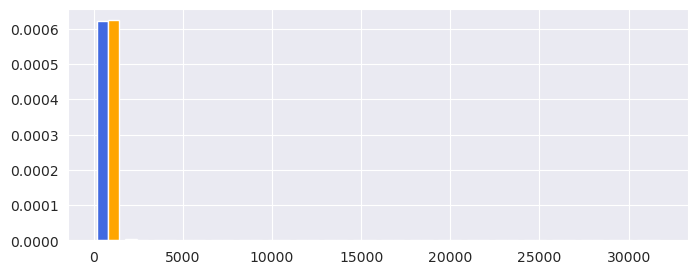

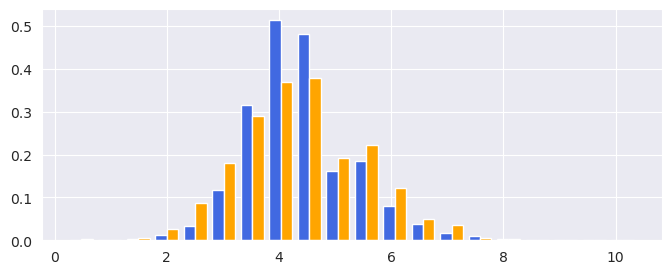

In [41]:
plotTrnHistByFraud('TransactionAmt')
plotTrnLogHistByFraud('TransactionAmt')

In [42]:
amt_desc = pd.concat([train_trn_f0['TransactionAmt'].describe(), train_trn_f1['TransactionAmt'].describe()], axis=1)
amt_desc.columns = ['normal','fraud']
amt_desc

,normal,fraud
count,"569,877.000","20,663.000"
mean,NaN,inf
std,NaN,inf
min,0.251,0.292
25%,43.969,35.031
50%,68.500,75.000
75%,120.000,161.000
max,"31,936.000","5,192.000"


In [43]:
def appendLagAmt(df):
    df = df.assign(_amt_lag = df['TransactionAmt'] - df.groupby(['card1','card2'])['TransactionAmt'].shift(1))
    df['_amt_lag_sig'] = df['_amt_lag'].apply(lambda x: '0' if np.isnan(x) else '+' if x >=0 else '-')
    return df

train_trn = appendLagAmt(train_trn)
train_trn_f0 = train_trn[train_trn['isFraud'] == 0]
train_trn_f1 = train_trn[train_trn['isFraud'] == 1]

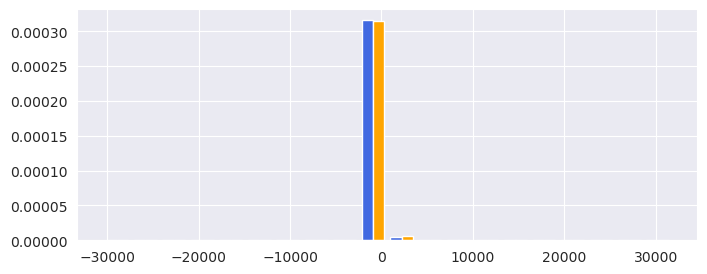

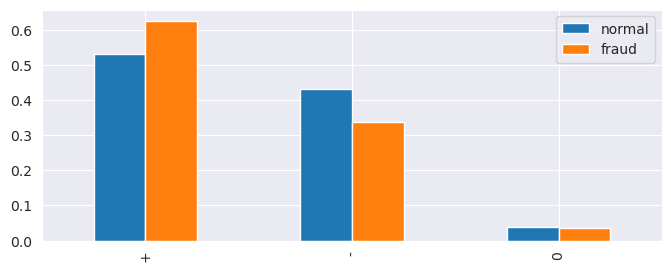

In [44]:
plotTrnHistByFraud('_amt_lag')
plotTrnCategoryRateBar('_amt_lag_sig')

### ProductCD

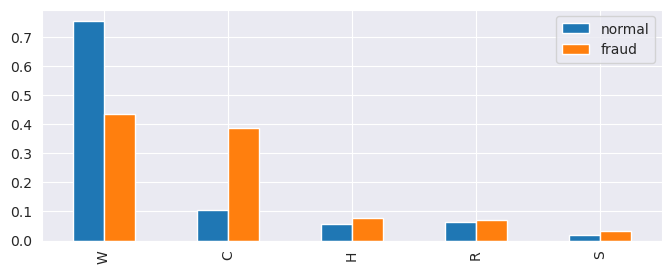

In [45]:
plotTrnCategoryRateBar('ProductCD')

In [46]:
cols = ['ProductCD','addr1','addr2','dist1','dist2']
train_trn[cols].head(20)

,ProductCD,addr1,addr2,dist1,dist2
0,W,315.000,87.000,19.000,NaN
1,W,325.000,87.000,NaN,NaN
2,W,330.000,87.000,287.000,NaN
3,W,476.000,87.000,NaN,NaN
4,H,420.000,87.000,NaN,NaN
5,W,272.000,87.000,36.000,NaN
6,W,126.000,87.000,0.000,NaN
7,W,325.000,87.000,NaN,NaN
8,H,337.000,87.000,NaN,NaN
9,W,204.000,87.000,19.000,NaN


In [47]:
cols = ['addr1','addr2','dist1','dist2']
for f in cols:
    train_trn[f + '_isna'] = train_trn[f].isna()

In [48]:
pd.crosstab(train_trn['ProductCD'], train_trn['addr1_isna'])

addr1_isna,False,True
ProductCD,,
C,3400,65119
H,32940,84
R,37649,50
S,11419,209
W,439426,244


In [49]:
pd.crosstab(train_trn['ProductCD'], train_trn['dist1_isna'])

dist1_isna,False,True
ProductCD,,
C,0,68519
H,0,33024
R,0,37699
S,0,11628
W,238269,201401


In [50]:
pd.crosstab(train_trn['ProductCD'], train_trn['dist2_isna'])

dist2_isna,False,True
ProductCD,,
C,26741,41778
H,901,32123
R,5524,32175
S,4461,7167
W,0,439670


In [51]:
train_trn[(train_trn['dist1_isna'] == False) & (train_trn['dist2_isna'] == False)][cols]

,addr1,addr2,dist1,dist2


In [52]:
train_trn = pd.concat([train_trn, pd.get_dummies(train_trn[['ProductCD']])], axis=1)
train_trn.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,_amt_lag_sig,addr1_isna,addr2_isna,dist1_isna,dist2_isna,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,2987000,0,86400,68.500,W,13926,NaN,150.000,discover,142.000,...,0,False,False,False,True,0,0,0,0,1
1,2987001,0,86401,29.000,W,2755,404.000,150.000,mastercard,102.000,...,0,False,False,True,True,0,0,0,0,1
2,2987002,0,86469,59.000,W,4663,490.000,150.000,visa,166.000,...,0,False,False,False,True,0,0,0,0,1
3,2987003,0,86499,50.000,W,18132,567.000,150.000,mastercard,117.000,...,0,False,False,True,True,0,0,0,0,1
4,2987004,0,86506,50.000,H,4497,514.000,150.000,mastercard,102.000,...,0,False,False,True,True,0,1,0,0,0


In [53]:
cols = ['ProductCD_W','ProductCD_C','ProductCD_H','ProductCD_R','ProductCD_S','dist1_isna','dist2_isna','addr1_isna','addr2_isna']
train_trn[cols].corr()

,ProductCD_W,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,dist1_isna,dist2_isna,addr1_isna,addr2_isna
ProductCD_W,1.000,-0.618,-0.415,-0.446,-0.242,-0.482,0.445,-0.601,-0.601
ProductCD_C,-0.618,1.000,-0.088,-0.095,-0.051,0.298,-0.484,0.967,0.967
ProductCD_H,-0.415,-0.088,1.000,-0.064,-0.034,0.200,0.036,-0.084,-0.084
ProductCD_R,-0.446,-0.095,-0.064,1.000,-0.037,0.215,-0.089,-0.091,-0.091
ProductCD_S,-0.242,-0.051,-0.034,-0.037,1.000,0.117,-0.186,-0.042,-0.042
dist1_isna,-0.482,0.298,0.200,0.215,0.117,1.000,-0.215,0.290,0.290
dist2_isna,0.445,-0.484,0.036,-0.089,-0.186,-0.215,1.000,-0.462,-0.462
addr1_isna,-0.601,0.967,-0.084,-0.091,-0.042,0.290,-0.462,1.000,1.000
addr2_isna,-0.601,0.967,-0.084,-0.091,-0.042,0.290,-0.462,1.000,1.000


In [54]:
train_trn['_amount_max_ProductCD'] = train_trn.groupby(['ProductCD'])['TransactionAmt'].transform('max')
train_trn[['ProductCD','_amount_max_ProductCD']].drop_duplicates().sort_values(by='_amount_max_ProductCD', ascending=False)

,ProductCD,_amount_max_ProductCD
0,W,"31,936.000"
99,R,"1,800.000"
38,S,"1,550.000"
10,C,713.000
4,H,500.000


### card1 - card6

In [55]:
cols = [f'card{n}' for n in range(1,7)]
train_trn[cols].isnull().sum()

card1       0
card2    8933
card3    1565
card4    1577
card5    4259
card6    1571
dtype: int64

In [56]:
train_trn[cols].nunique()

card1    13553
card2      500
card3      114
card4        4
card5      119
card6        4
dtype: int64

In [57]:
train_trn[cols].head(10)

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.000,discover,142.000,credit
1,2755,404.000,150.000,mastercard,102.000,credit
2,4663,490.000,150.000,visa,166.000,debit
3,18132,567.000,150.000,mastercard,117.000,debit
4,4497,514.000,150.000,mastercard,102.000,credit
5,5937,555.000,150.000,visa,226.000,debit
6,12308,360.000,150.000,visa,166.000,debit
7,12695,490.000,150.000,visa,226.000,debit
8,2803,100.000,150.000,visa,226.000,debit
9,17399,111.000,150.000,mastercard,224.000,debit


<AxesSubplot:>

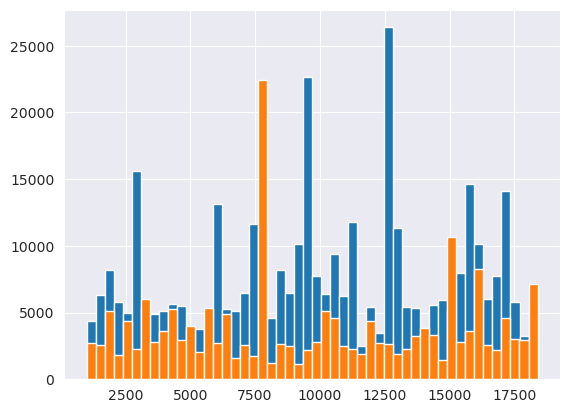

In [58]:
train_trn[train_trn['card4']=='visa']['card1'].hist(bins=50)
train_trn[train_trn['card4']=='mastercard']['card1'].hist(bins=50)

<AxesSubplot:>

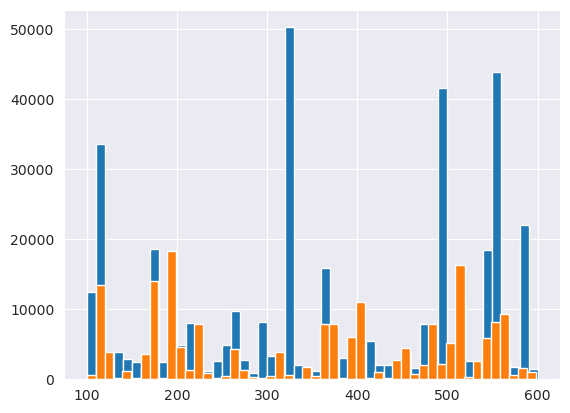

In [59]:
train_trn[train_trn['card4']=='visa']['card2'].hist(bins=50)
train_trn[train_trn['card4']=='mastercard']['card2'].hist(bins=50)

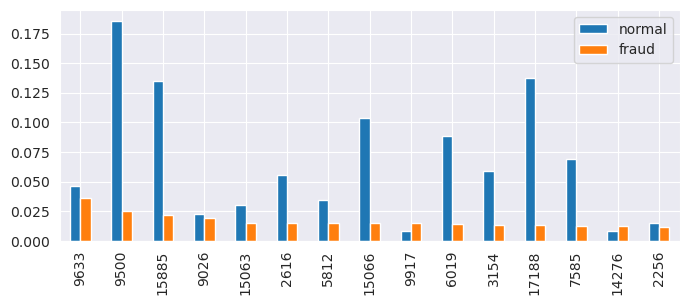

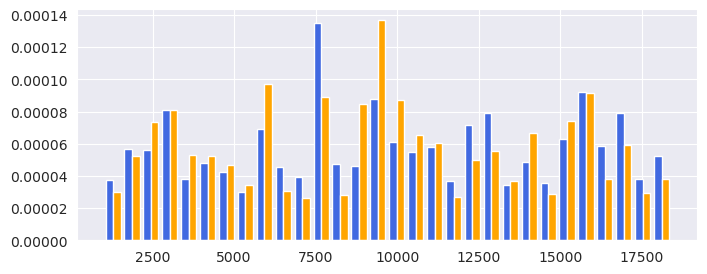

In [60]:
plotTrnCategoryRateBar('card1', 15)
plotTrnHistByFraud('card1', bins=30)

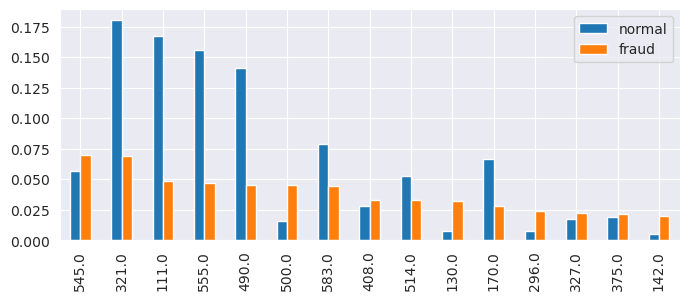

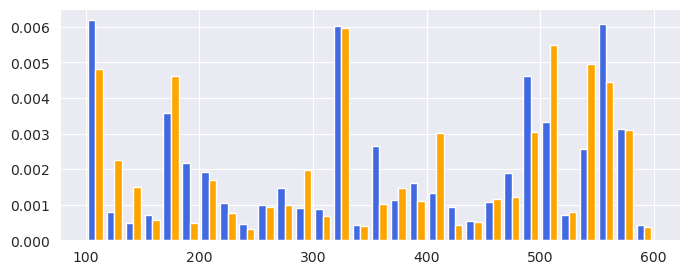

In [61]:
plotTrnCategoryRateBar('card2', 15)
plotTrnHistByFraud('card2', bins=30)

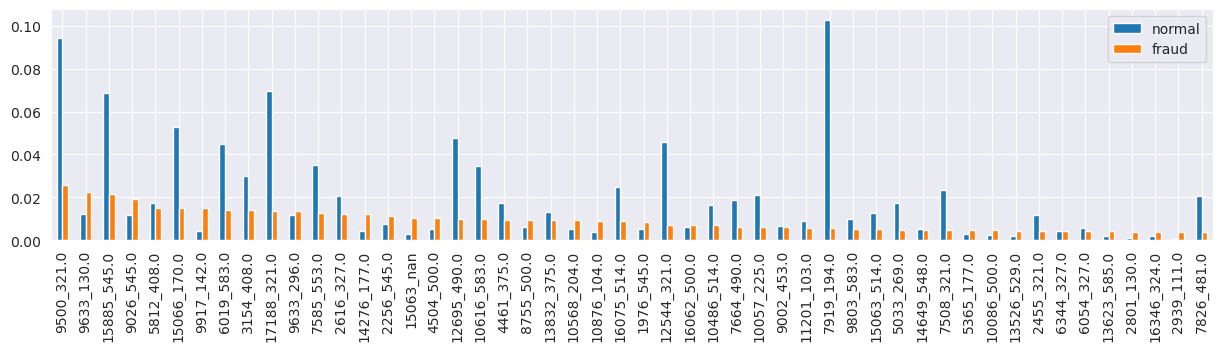

In [62]:
train_trn_f0['_card1_card2'] = train_trn_f0['card1'].astype(str) + '_' + train_trn_f0['card2'].astype(str)
train_trn_f1['_card1_card2'] = train_trn_f1['card1'].astype(str) + '_' + train_trn_f1['card2'].astype(str)

plotTrnCategoryRateBar('_card1_card2', 50, figsize=(15,3))

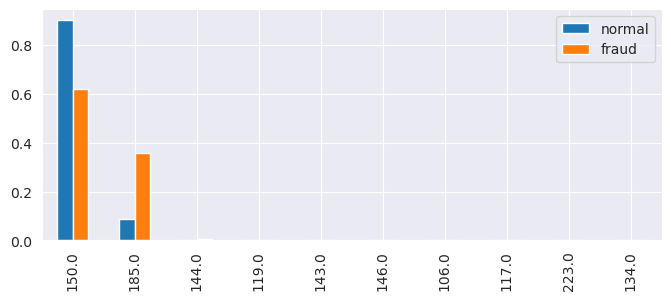

In [63]:
plotTrnCategoryRateBar('card3', 10)

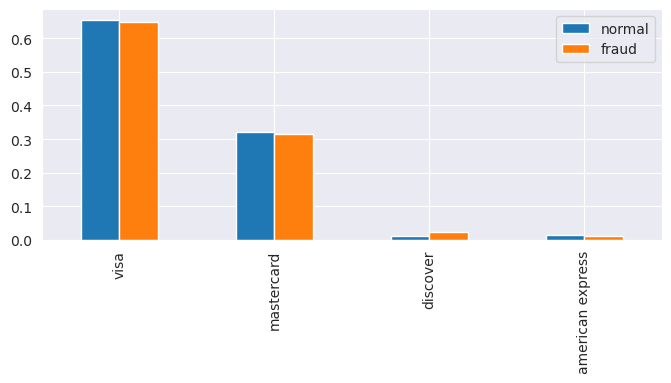

In [64]:
plotTrnCategoryRateBar('card4')

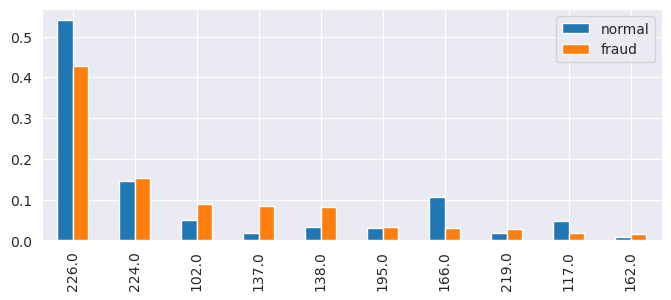

In [65]:
plotTrnCategoryRateBar('card5', 10)

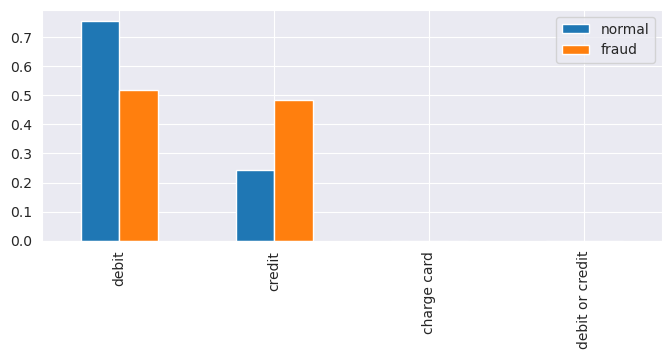

In [66]:
plotTrnCategoryRateBar('card6')

In [67]:
print(len(train_trn))
print(train_trn['card1'].nunique(), train_trn['card2'].nunique(), train_trn['card3'].nunique(), train_trn['card5'].nunique())

train_trn['card_n'] = (train_trn['card1'].astype(str) + '_' + train_trn['card2'].astype(str) \
       + '_' + train_trn['card3'].astype(str) + '_' + train_trn['card5'].astype(str))
print('unique cards:', train_trn['card_n'].nunique())

590540
13553 500 114 119
unique cards: 14845


<AxesSubplot:>

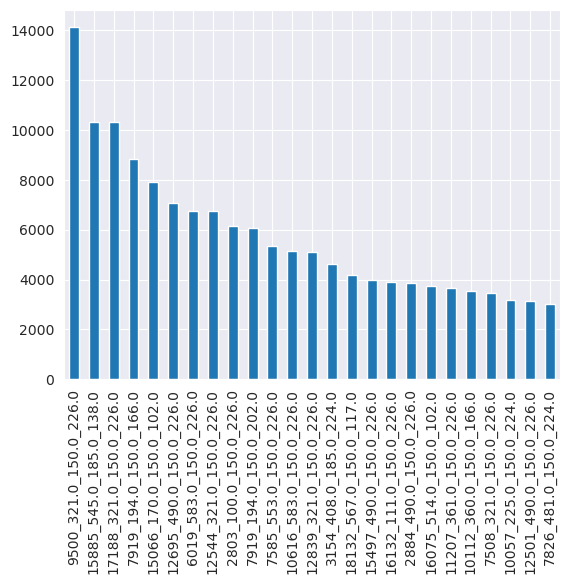

In [68]:
vc = train_trn['card_n'].value_counts()
vc[vc > 3000].plot.bar()

In [69]:
train_trn.groupby(['card_n'])['isFraud'].mean().sort_values(ascending=False)

card_n
17539_555.0_150.0_226.0   1.000
4154_555.0_121.0_232.0    1.000
14157_555.0_185.0_102.0   1.000
2497_383.0_150.0_195.0    1.000
14173_512.0_150.0_195.0   1.000
                           ... 
1555_582.0_150.0_224.0    0.000
15560_111.0_150.0_129.0   0.000
15560_111.0_150.0_195.0   0.000
15561_540.0_106.0_166.0   0.000
9999_174.0_150.0_226.0    0.000
Name: isFraud, Length: 14845, dtype: float64

### addr1, addr2

In [70]:
train_trn['addr1'].nunique(), train_trn['addr2'].nunique()

(332, 74)

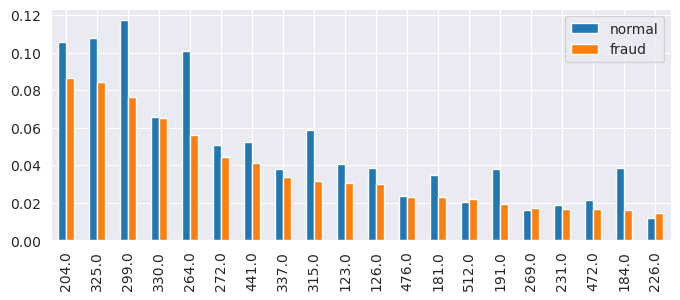

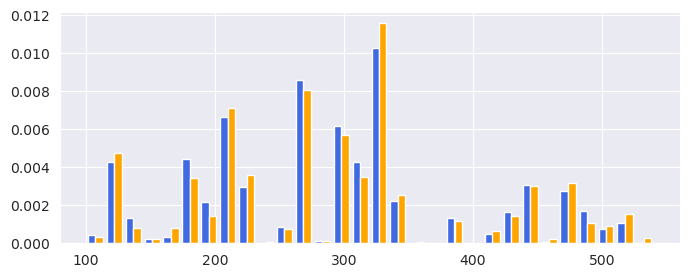

In [71]:
plotTrnCategoryRateBar('addr1', 20)
plotTrnHistByFraud('addr1', bins=30)

In [72]:
train_trn['addr1'].value_counts(dropna=False).to_frame().iloc[:10]

,addr1
NaN,65706
299.000,46335
325.000,42751
204.000,42020
264.000,39870
330.000,26287
315.000,23078
441.000,20827
272.000,20141
123.000,16105


addr2 nunique: 74


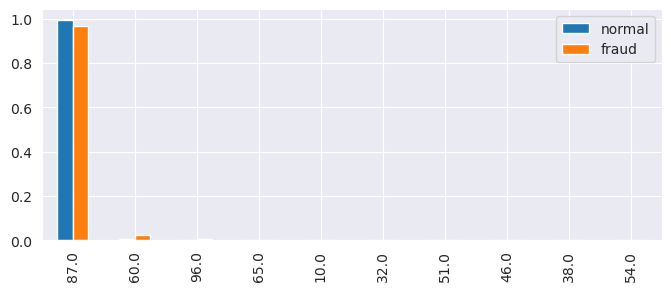

In [73]:
plotTrnCategoryRateBar('addr2', 10)
print('addr2 nunique:', train_trn['addr2'].nunique())

In [74]:
train_trn['addr2'].value_counts(dropna=False).to_frame().iloc[:10]

,addr2
87.000,520481
NaN,65706
60.000,3084
96.000,638
32.000,91
65.000,82
16.000,55
31.000,47
19.000,33
26.000,25


### dist1, dist2

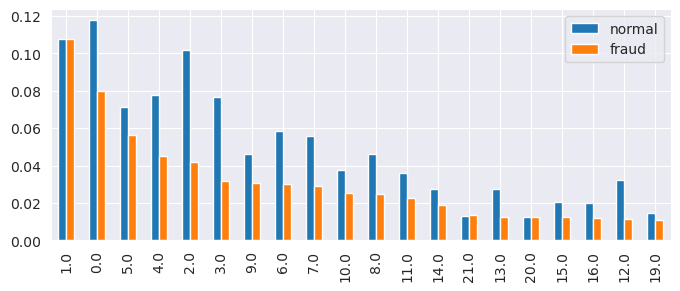

In [75]:
plotTrnCategoryRateBar('dist1', 20)

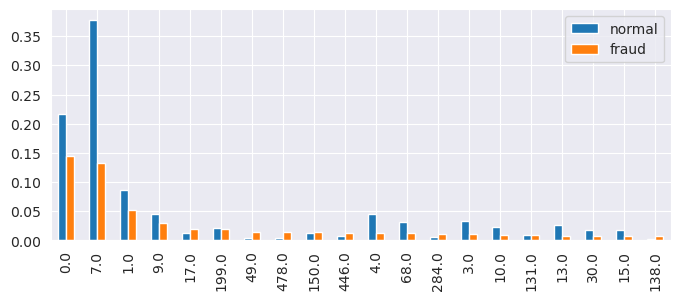

In [76]:
plotTrnCategoryRateBar('dist2', 20)

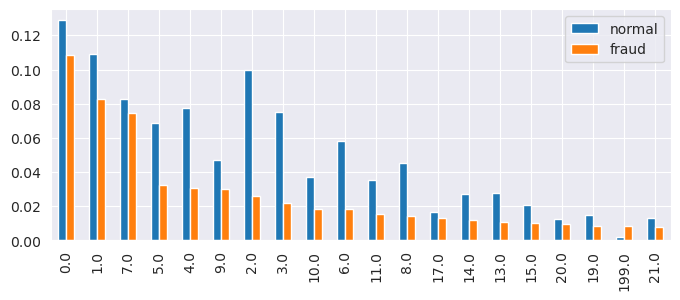

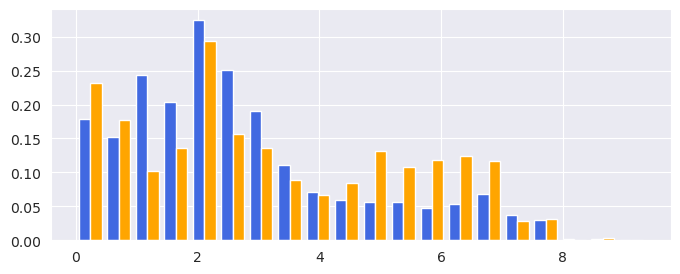

In [77]:
train_trn_f0['dist3'] = np.where(train_trn_f0['dist1'].isna(), train_trn_f0['dist2'], train_trn_f0['dist1'])
train_trn_f1['dist3'] = np.where(train_trn_f1['dist1'].isna(), train_trn_f1['dist2'], train_trn_f1['dist1'])

plotTrnCategoryRateBar('dist3', 20)
plotTrnLogHistByFraud('dist3')

### P_emaildomain, R_emaildomain

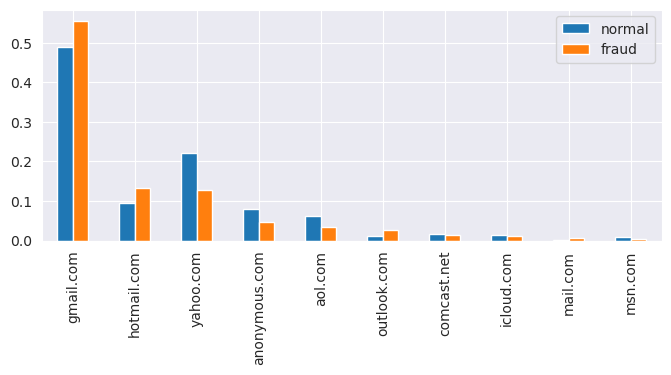

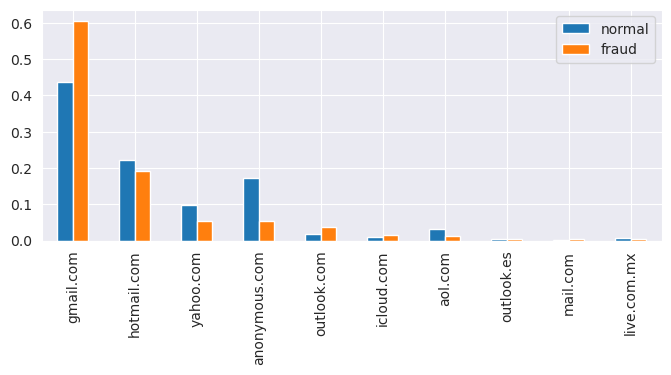

In [78]:
plotTrnCategoryRateBar('P_emaildomain',10)
plotTrnCategoryRateBar('R_emaildomain',10)

In [79]:
train_trn['P_emaildomain'].fillna('unknown',inplace=True)
train_trn['R_emaildomain'].fillna('unknown',inplace=True)

inf = pd.DataFrame([], columns=['P_emaildomain','R_emaildomain','Count','isFraud'])
for n in (train_trn['P_emaildomain'] + ' ' + train_trn['R_emaildomain']).unique():
    p, r = n.split()[0], n.split()[1]
    df = train_trn[(train_trn['P_emaildomain'] == p) & (train_trn['R_emaildomain'] == r)]
    inf = inf.append(pd.DataFrame([p, r, len(df), df['isFraud'].mean()], index=inf.columns).T)

inf.sort_values(by='isFraud', ascending=False).head(10)

,P_emaildomain,R_emaildomain,Count,isFraud
0,yahoo.com,mail.com,1,1.000
0,anonymous.com,protonmail.com,2,1.000
0,aol.com,mail.com,3,1.000
0,unknown,protonmail.com,6,1.000
0,protonmail.com,gmail.com,4,1.000
0,protonmail.com,protonmail.com,23,1.000
0,yahoo.com,protonmail.com,1,1.000
0,gmail.com,protonmail.com,6,0.833
0,mail.com,hotmail.com,4,0.750
0,aol.com,protonmail.com,3,0.667


In [80]:
train_trn_f1['P_emaildomain_prefix'] = train_trn_f1['P_emaildomain'].fillna('unknown').apply(lambda x: x.split('.')[0])
pd.crosstab(train_trn_f1['P_emaildomain_prefix'], train_trn_f1['ProductCD']).T

P_emaildomain_prefix,aim,anonymous,aol,att,bellsouth,cableone,charter,comcast,cox,earthlink,...,protonmail,roadrunner,rocketmail,sbcglobal,sc,suddenlink,unknown,verizon,yahoo,ymail
ProductCD,,,,,,,,,,,,,,,,,,,,,
C,0,366,6,0,0,0,0,0,0,0,...,2,0,0,0,0,0,311,0,124,0
H,0,143,42,0,2,0,0,32,0,6,...,16,0,0,2,0,4,0,2,179,9
R,1,122,34,0,7,0,3,10,4,0,...,10,0,0,1,0,0,2,7,218,3
S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,686,0,0,0
W,39,228,535,30,44,3,22,204,25,5,...,3,3,2,9,1,0,1791,13,1799,38


<AxesSubplot:ylabel='P_emaildomain_prefix'>

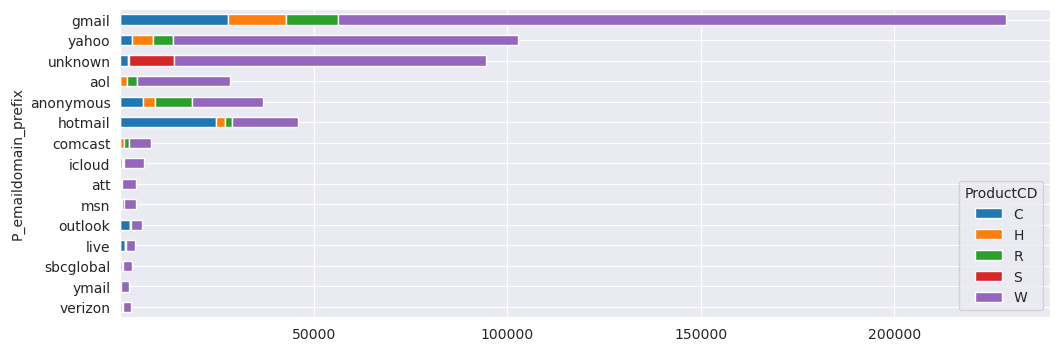

In [81]:
train_trn['P_emaildomain_prefix'] = train_trn['P_emaildomain'].apply(lambda x: x.split('.')[0])
ct = pd.crosstab(train_trn['P_emaildomain_prefix'], train_trn['ProductCD'])
ct = ct.sort_values(by='W')[-15:]
ct.plot.barh(stacked=True, figsize=(12,4))

### C1 - C14

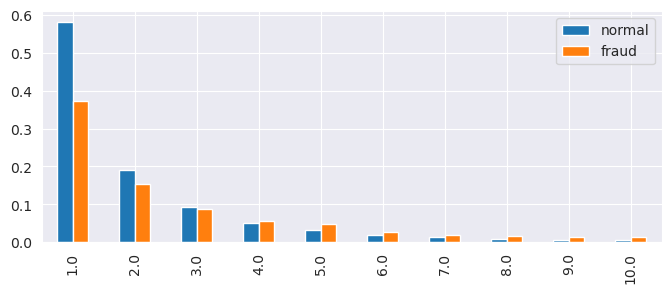

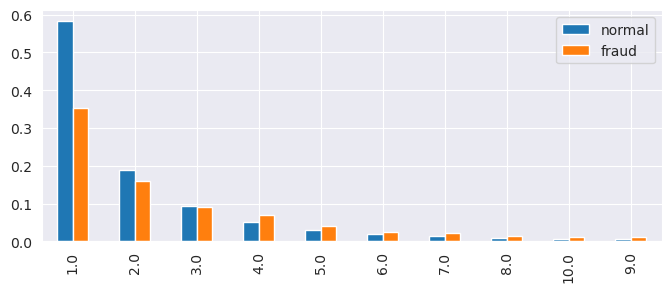

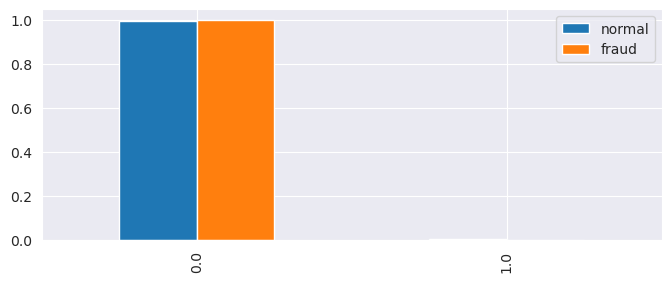

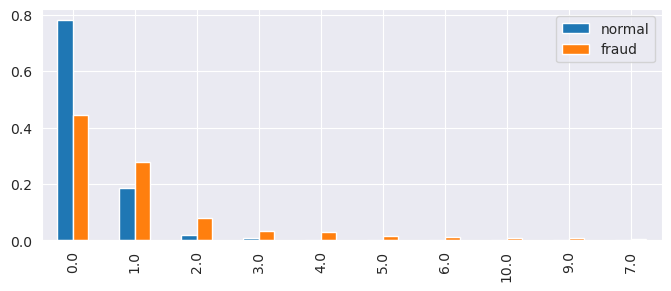

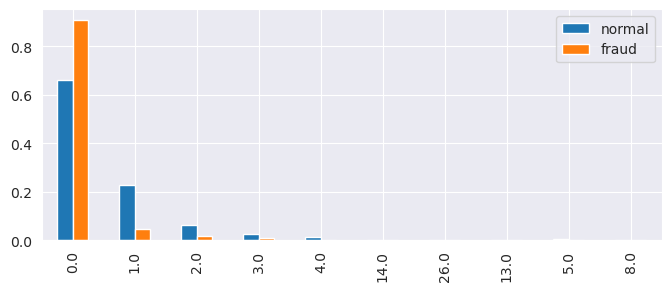

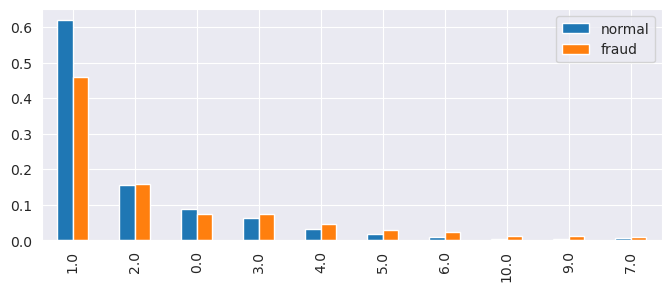

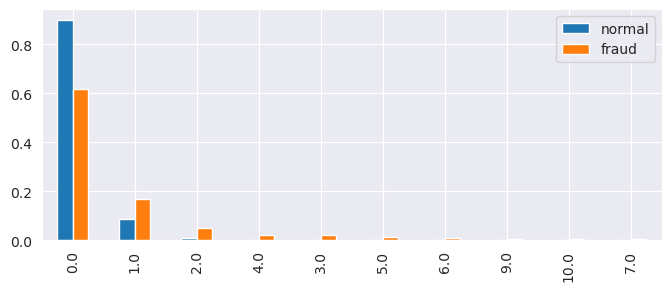

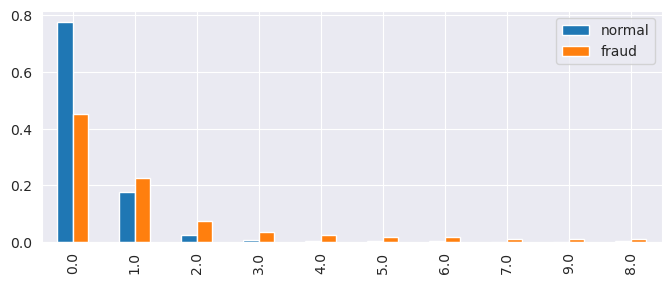

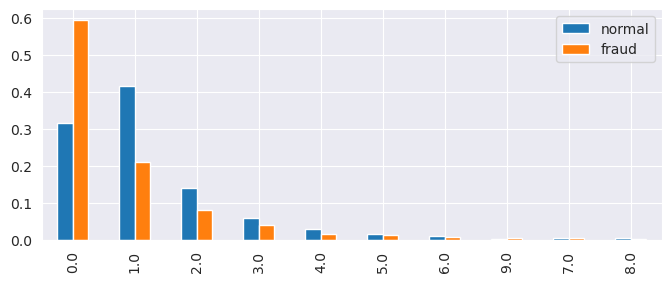

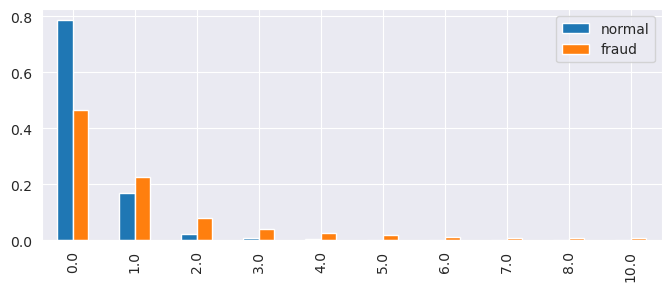

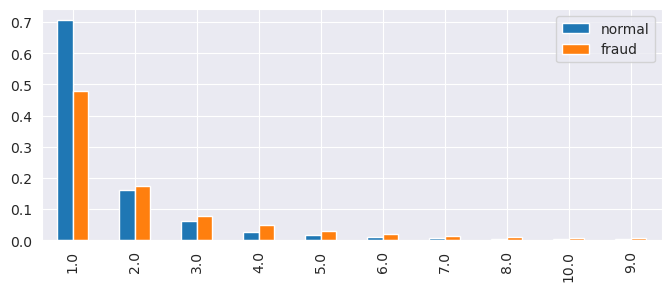

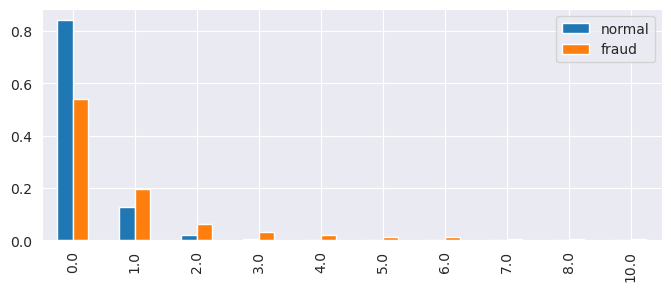

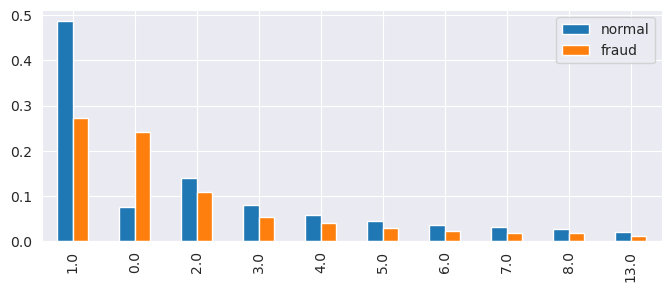

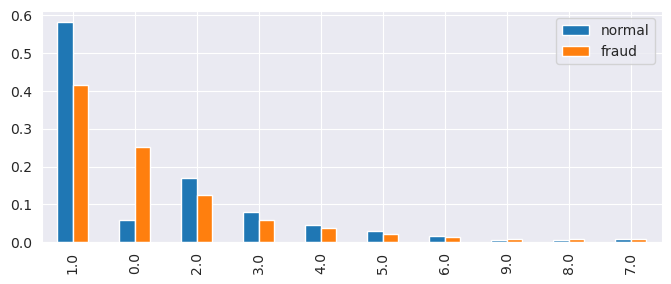

In [82]:
for i in range(1,15):
    plotTrnCategoryRateBar(f'C{i}',10)

In [83]:
train_trn[ccols].describe().loc[['count','mean','std','min','max']]

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,"590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000"
mean,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,"4,684.000","5,692.000",26.000,"2,252.000",349.000,"2,252.000","2,256.000","3,332.000",210.000,"3,256.000","3,188.000","3,188.000","2,918.000","1,429.000"


<AxesSubplot:>

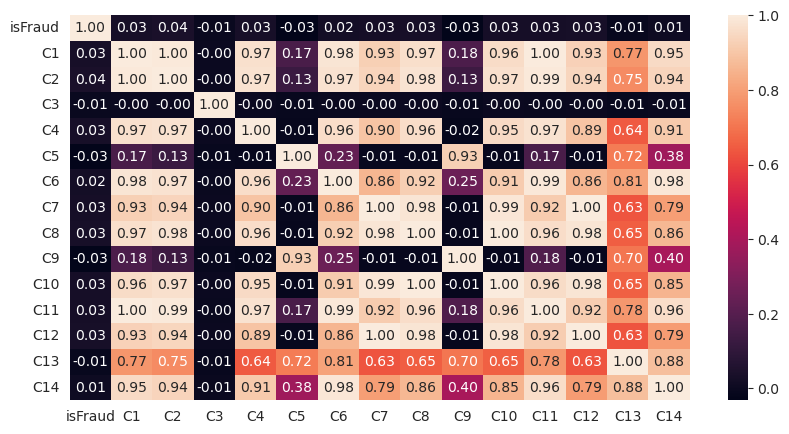

In [84]:
plt.figure(figsize=(10,5))

corr = train_trn[['isFraud'] + ccols].corr()
sns.heatmap(corr, annot=True, fmt='.2f')

- Cx & card

In [85]:
cols = ['TransactionDT','TransactionAmt','isFraud'] + ccols
train_trn[train_trn['card1'] == 9500][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
107,88258,226.000,0,3.000,3.000,0.000,0.000,0.000,2.000,0.000,0.000,1.000,0.000,2.000,0.000,8.000,2.000
122,88538,80.000,0,21.000,25.000,0.000,0.000,33.000,22.000,0.000,0.000,17.000,0.000,19.000,0.000,99.000,18.000
161,89085,107.938,0,1.000,1.000,0.000,0.000,4.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,5.000,1.000
174,89250,107.938,0,3.000,3.000,0.000,0.000,7.000,1.000,0.000,0.000,2.000,0.000,2.000,0.000,31.000,3.000
225,89969,43.000,0,2.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,2.000,0.000,1.000,0.000,7.000,2.000
255,90440,54.000,0,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000
332,91758,100.000,0,1.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000
335,91804,100.000,0,1.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000
336,91824,100.000,0,1.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000
338,91884,100.000,0,1.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000


In [86]:
cols = ['TransactionDT','TransactionAmt','isFraud'] + ccols
train_trn[train_trn['card1'] == 4774][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
389687,9766493,445.000,1,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000
393954,9906065,445.000,1,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000
393970,9906367,445.000,1,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000
394352,9913683,445.000,1,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000
394372,9913975,445.000,1,1.000,1.000,0.000,0.000,0.000,2.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000
394375,9914050,426.000,1,1.000,1.000,0.000,0.000,0.000,2.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000


In [87]:
train_trn[train_trn['card1'] == 14770][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
78089,1706422,64.688,1,1.000,1.000,0.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
78134,1706831,64.688,1,1.000,2.000,0.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,2.000,2.000,1.000,1.000


### D1-D15

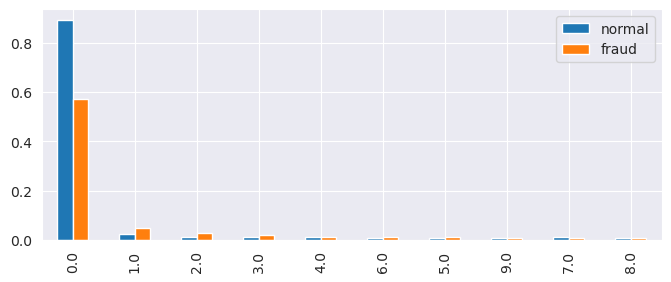

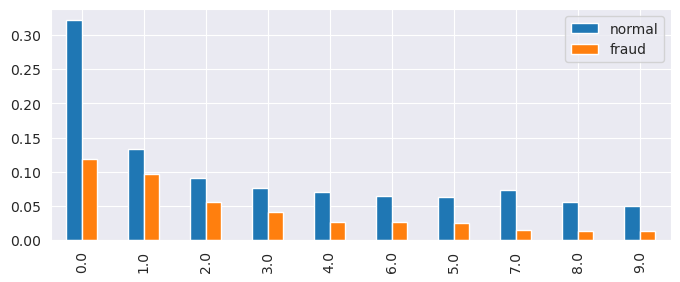

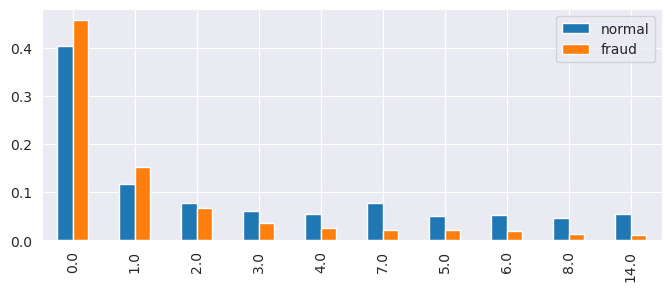

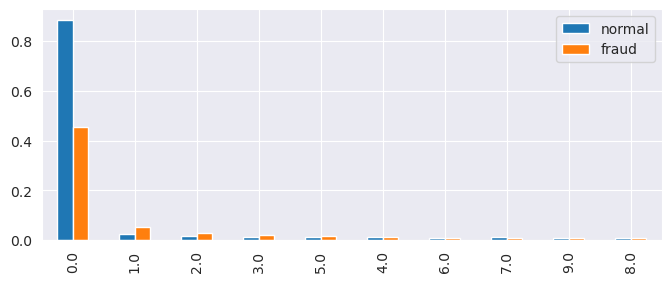

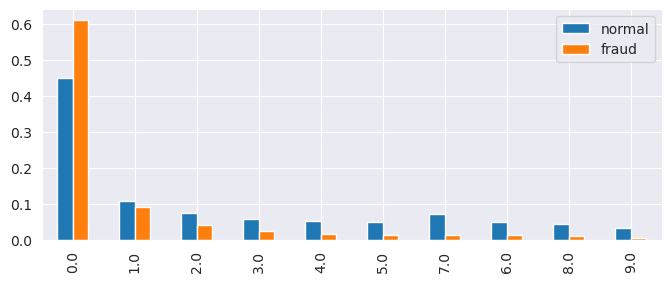

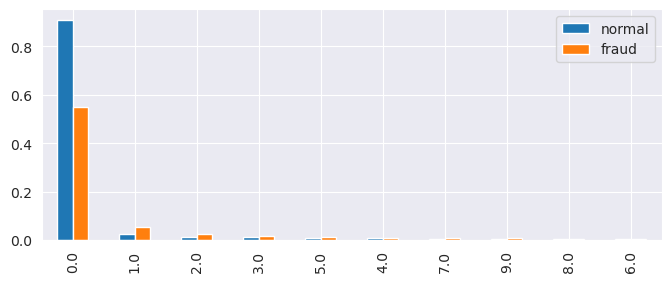

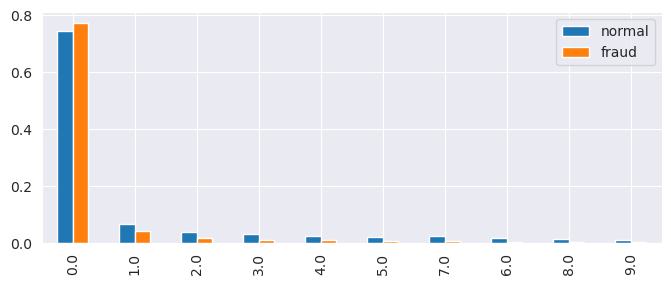

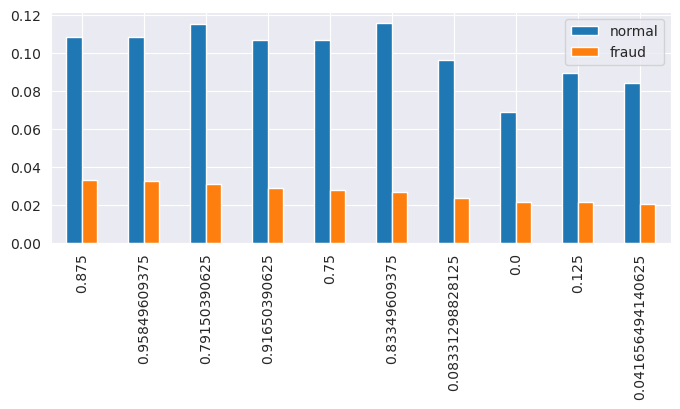

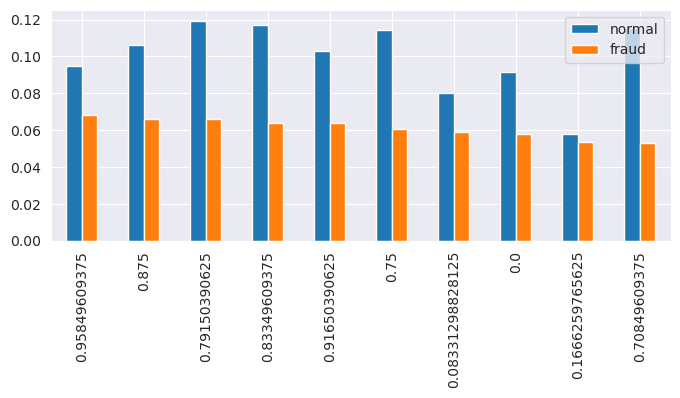

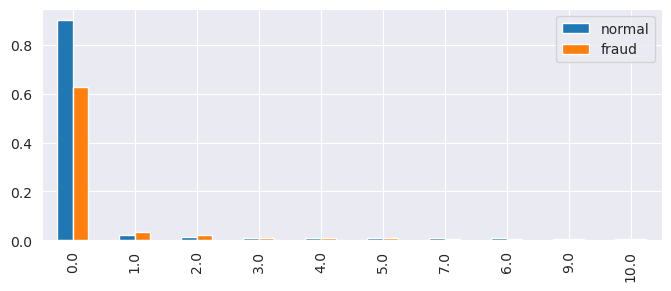

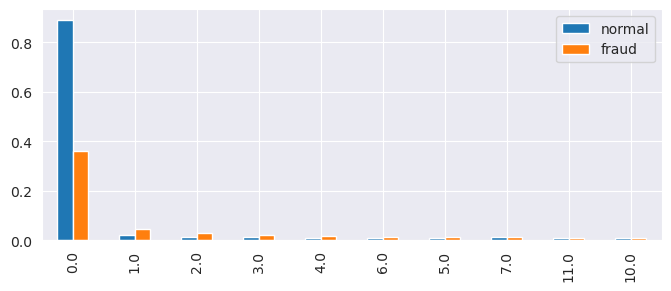

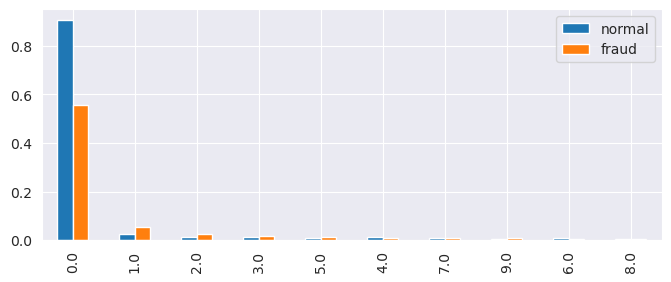

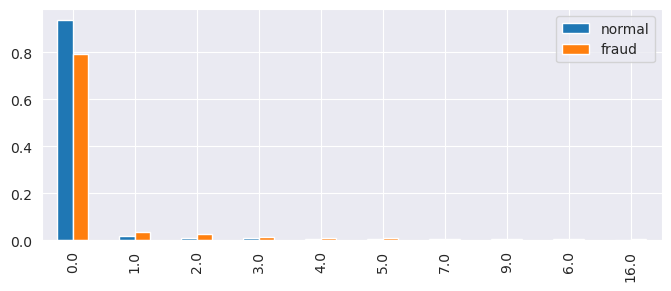

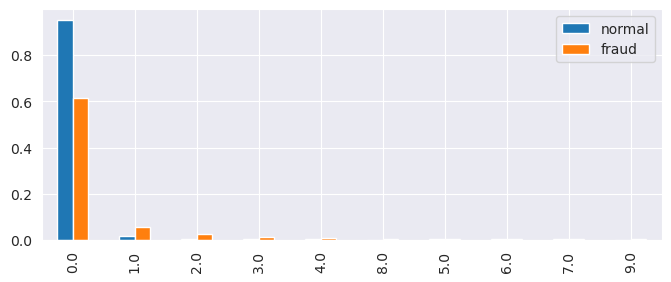

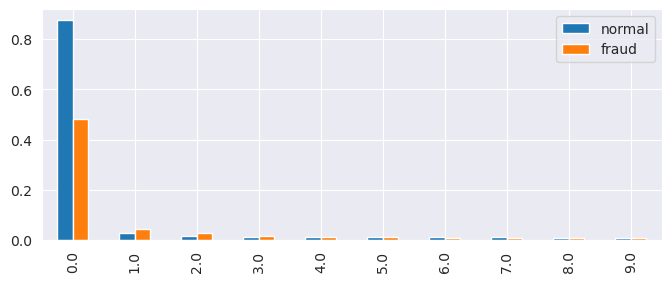

In [88]:
for i in range(1,16):
    plotTrnCategoryRateBar(f'D{i}',10)

In [89]:
train_trn[dcols].describe().loc[['count','mean','std','min','max']]

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
count,"589,271.000","309,743.000","327,662.000","421,618.000","280,699.000","73,187.000","38,917.000","74,926.000","74,926.000","514,518.000","311,253.000","64,717.000","61,952.000","62,187.000","501,427.000"
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.000,NaN,NaN,inf,inf,inf,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.000,NaN,NaN,inf,inf,inf,NaN
min,0.000,0.000,0.000,-122.000,0.000,-83.000,0.000,0.000,0.000,0.000,-53.000,-83.000,0.000,-193.000,-83.000
max,640.000,640.000,819.000,869.000,819.000,873.000,843.000,"1,708.000",0.958,876.000,670.000,648.000,847.000,878.000,879.000


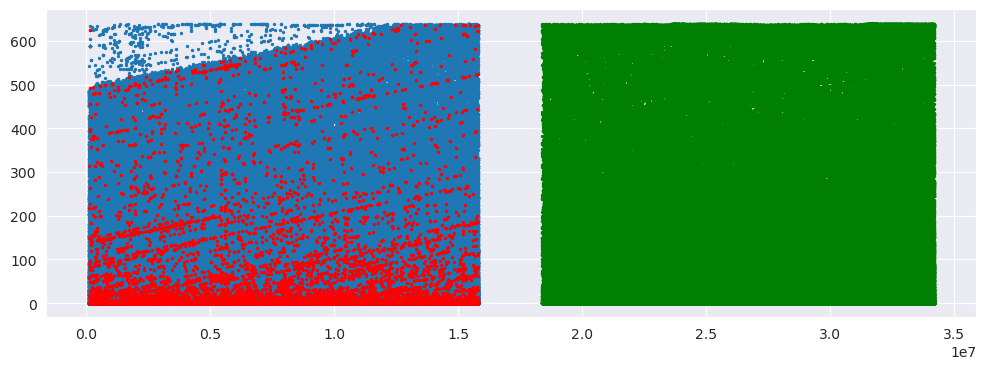

In [90]:
plt.figure(figsize=(12,4))

plt.scatter(train_trn_f0['TransactionDT'], train_trn_f0['D1'], s=2)
plt.scatter(train_trn_f1['TransactionDT'], train_trn_f1['D1'], s=2, c='r')
plt.scatter(test_trn['TransactionDT'], test_trn['D1'], s=2, c='g')

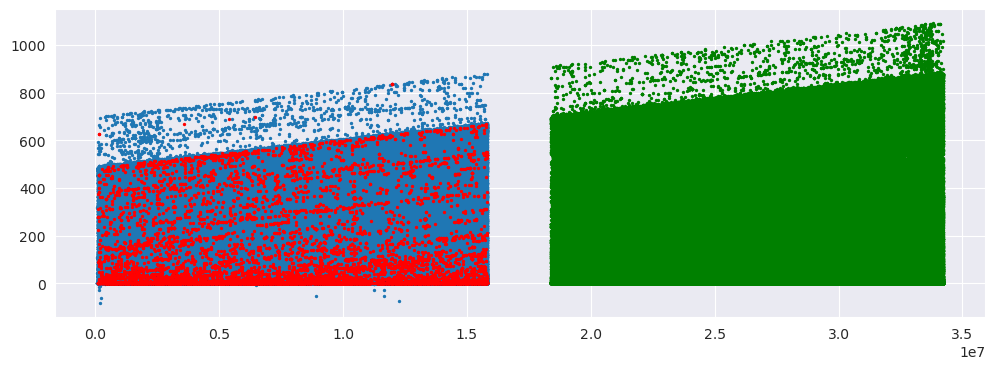

In [91]:
plt.figure(figsize=(12,4))

# ref. https://www.kaggle.com/kyakovlev/ieee-columns-scaling
plt.scatter(train_trn_f0['TransactionDT'], train_trn_f0['D15'], s=2)
plt.scatter(train_trn_f1['TransactionDT'], train_trn_f1['D15'], s=2, c='r')
plt.scatter(test_trn['TransactionDT'], test_trn['D15'], s=2, c='g')

<AxesSubplot:>

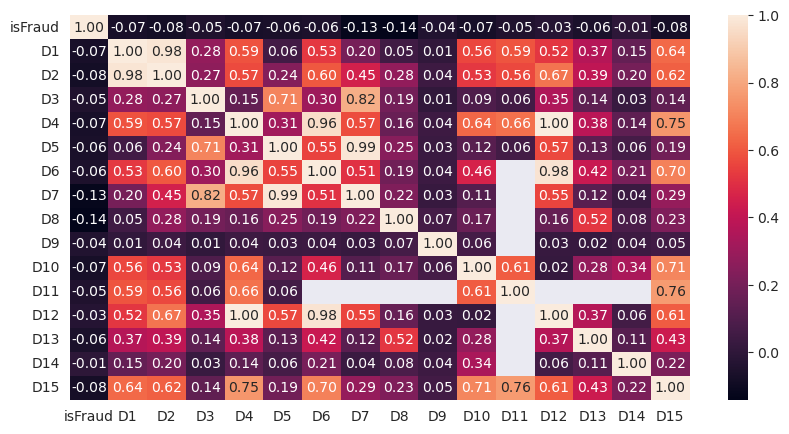

In [92]:
plt.figure(figsize=(10,5))

corr = train_trn[['isFraud'] + dcols].corr()
sns.heatmap(corr, annot=True, fmt='.2f')

array([<AxesSubplot:title={'center':'0'}>], dtype=object)

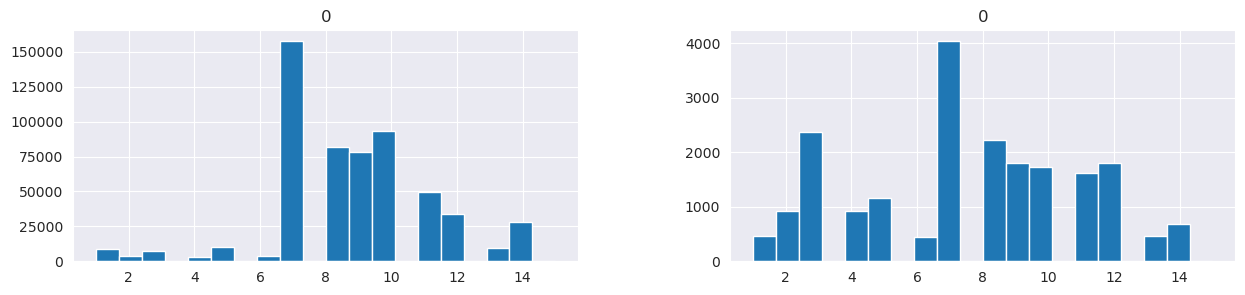

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
train_trn.loc[train_trn['isFraud']==0, dcols].isnull().sum(axis=1).to_frame().hist(ax=ax[0], bins=20)
train_trn.loc[train_trn['isFraud']==1, dcols].isnull().sum(axis=1).to_frame().hist(ax=ax[1], bins=20)

- Dx & card

In [94]:
cols = ['TransactionDT','TransactionAmt','isFraud'] + dcols
train_trn[train_trn['card1'] == 9500][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
107,88258,226.000,0,119.000,119.000,28.000,327.000,28.000,NaN,NaN,NaN,NaN,327.000,226.000,NaN,NaN,NaN,327.000
122,88538,80.000,0,416.000,416.000,39.000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,343.000,NaN,NaN,NaN,416.000
161,89085,107.938,0,125.000,125.000,59.000,124.000,59.000,NaN,NaN,NaN,NaN,124.000,NaN,NaN,NaN,NaN,124.000
174,89250,107.938,0,60.000,60.000,15.000,413.000,15.000,NaN,NaN,NaN,NaN,15.000,276.000,NaN,NaN,NaN,413.000
225,89969,43.000,0,86.000,86.000,4.000,299.000,4.000,NaN,NaN,NaN,NaN,299.000,NaN,NaN,NaN,NaN,299.000
255,90440,54.000,0,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,0.000
332,91758,100.000,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
335,91804,100.000,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.042,0.042,NaN,NaN,NaN,NaN,NaN,NaN
336,91824,100.000,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.042,0.042,NaN,NaN,NaN,NaN,NaN,NaN
338,91884,100.000,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.042,0.042,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
cols = ['TransactionDT','TransactionAmt','isFraud'] + dcols
train_trn[train_trn['card1'] == 4774][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
389687,9766493,445.000,1,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,0.000
393954,9906065,445.000,1,1.000,1.000,2.000,2.000,2.000,NaN,NaN,NaN,NaN,2.000,2.000,NaN,NaN,NaN,2.000
393970,9906367,445.000,1,1.000,1.000,0.000,2.000,0.000,NaN,NaN,NaN,NaN,2.000,2.000,NaN,NaN,NaN,2.000
394352,9913683,445.000,1,1.000,1.000,0.000,2.000,0.000,NaN,NaN,NaN,NaN,2.000,2.000,NaN,NaN,NaN,2.000
394372,9913975,445.000,1,1.000,1.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,2.000,2.000,NaN,NaN,NaN,2.000
394375,9914050,426.000,1,1.000,1.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,2.000,2.000,NaN,NaN,NaN,2.000


In [96]:
train_trn[train_trn['card1'] == 14770][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
78089,1706422,64.688,1,0.000,NaN,NaN,0.000,NaN,0.000,NaN,0.750,0.750,0.000,NaN,0.000,0.000,0.000,0.000
78134,1706831,64.688,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.750,0.750,0.000,NaN,0.000,0.000,0.000,0.000


### M1 - M9

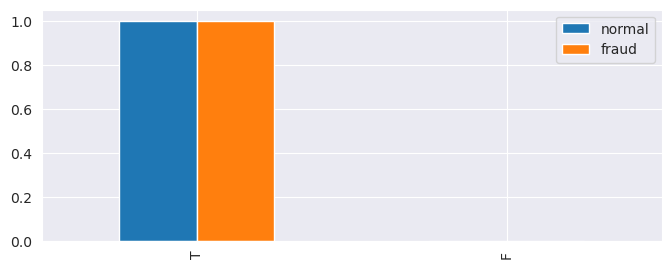

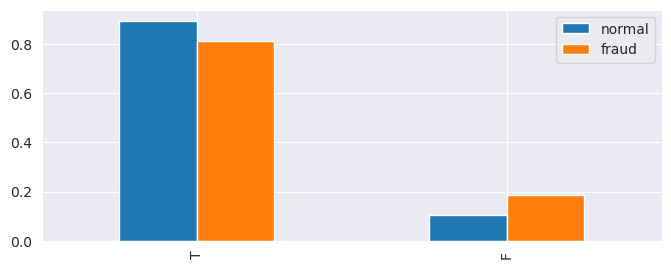

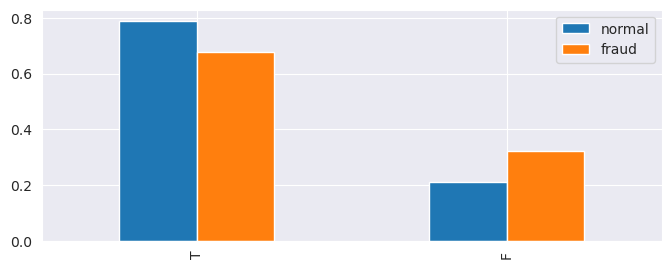

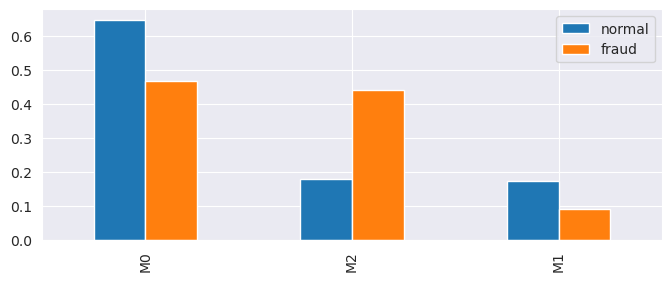

In [97]:
plotTrnCategoryRateBar('M1')
plotTrnCategoryRateBar('M2')
plotTrnCategoryRateBar('M3')
plotTrnCategoryRateBar('M4')

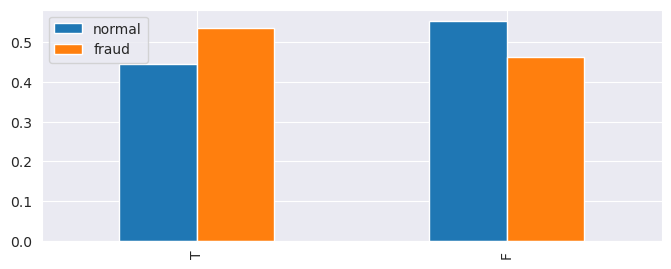

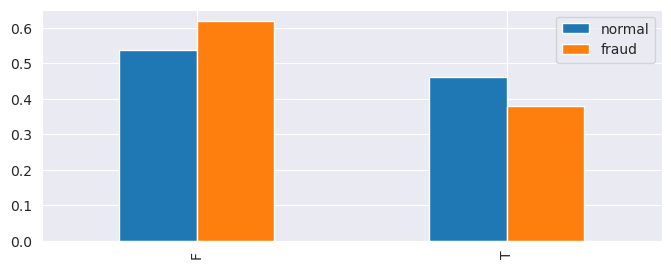

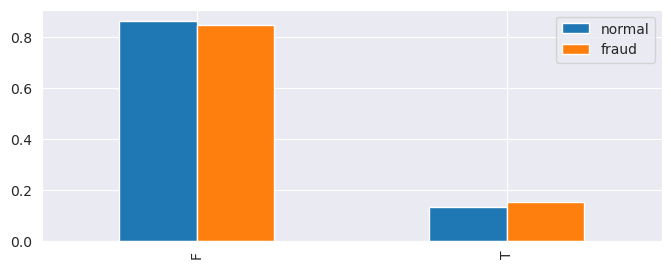

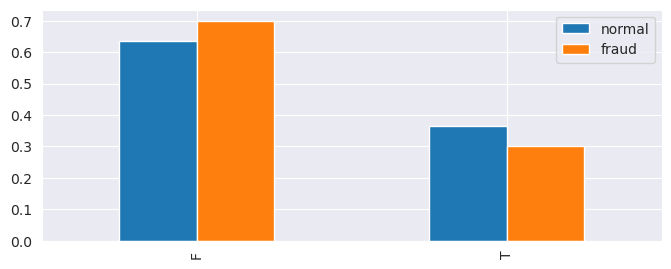

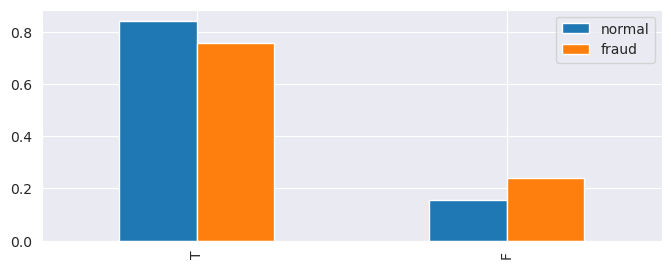

In [98]:
plotTrnCategoryRateBar('M5')
plotTrnCategoryRateBar('M6')
plotTrnCategoryRateBar('M7')
plotTrnCategoryRateBar('M8')
plotTrnCategoryRateBar('M9')

### Vxxx

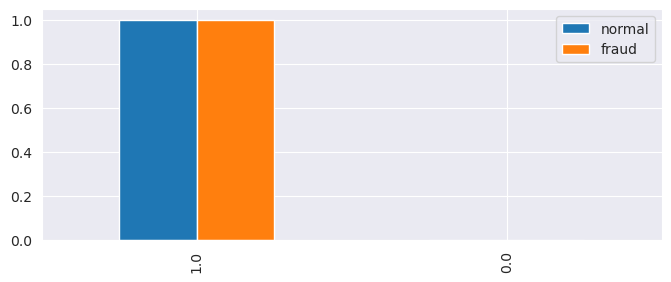

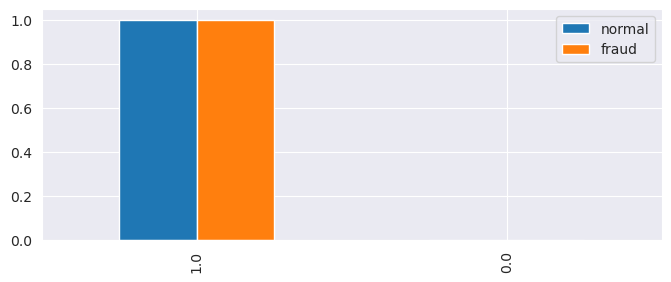

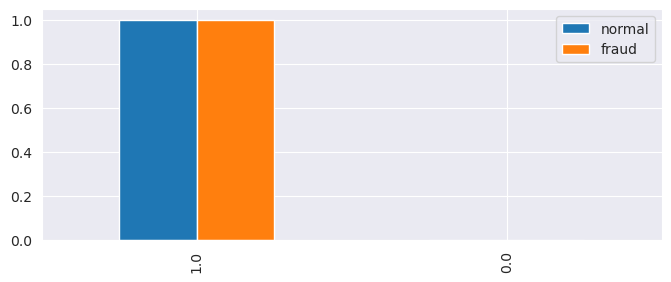

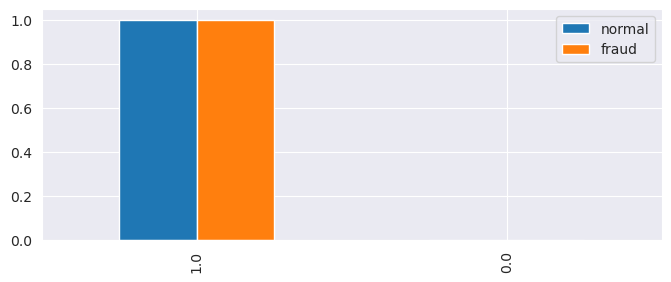

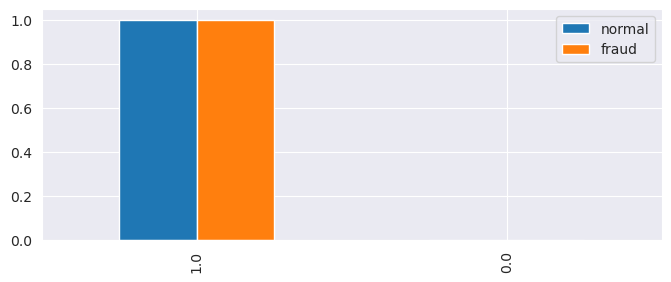

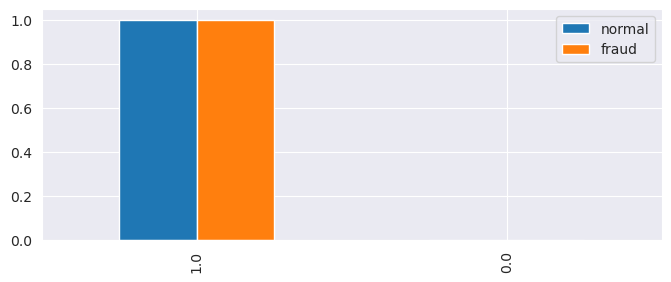

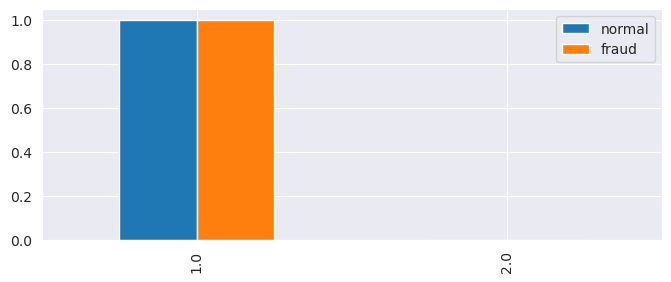

In [99]:
for f in ['V1','V14','V41','V65','V88','V107','V305']:
    plotTrnCategoryRateBar(f)

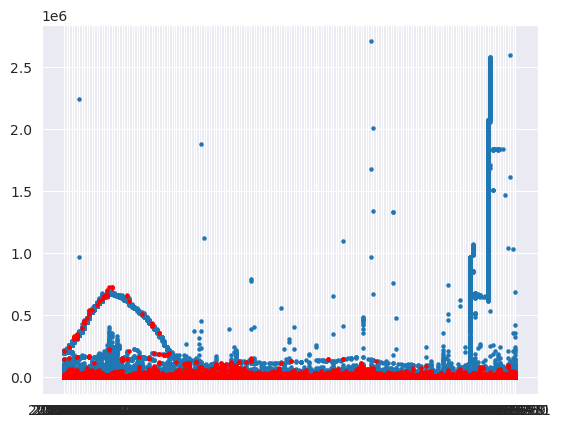

In [100]:
vsum0 = train_trn_f0[vcols].sum(axis=1)
vsum1 = train_trn_f1[vcols].sum(axis=1)
plt.scatter(train_trn_f0['_ymd'], vsum0, s=5)
plt.scatter(train_trn_f1['_ymd'], vsum1, s=5, c='r')

In [101]:
m = train_trn_f1[vcols].describe().T['max']
m[m >= 10000]

V127    19,860.000
V128    10,162.000
V133    15,607.000
V159    43,552.000
V160   639,717.438
V165    17,468.949
V202    10,900.000
V203    81,450.000
V204    37,850.000
V207    20,080.000
V212    34,625.000
V213    16,950.000
V215    13,725.000
V264    10,035.000
V306    11,848.000
V307    83,258.367
V308    18,123.957
V316    11,848.000
V317    82,130.953
V318    18,123.957
Name: max, dtype: float64

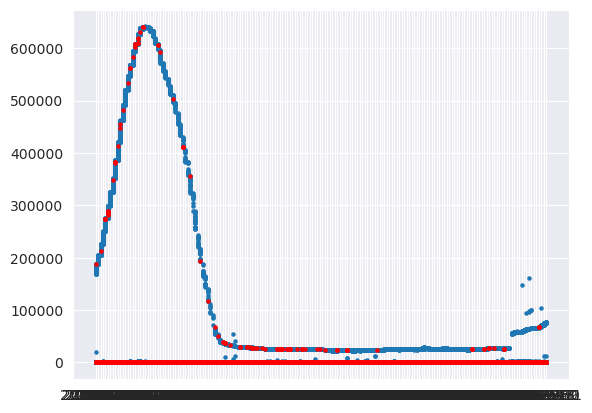

In [102]:
plt.scatter(train_trn_f0['_ymd'], train_trn_f0['V160'], s=5)
plt.scatter(train_trn_f1['_ymd'], train_trn_f1['V160'], s=5, c='r')

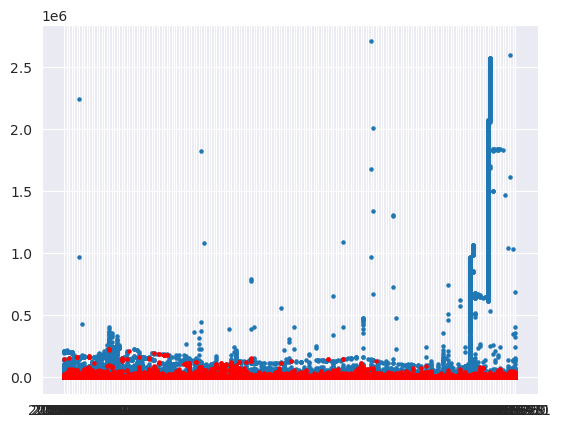

In [103]:
vcols_1 = [f'V{i}' for i in range(1,160)]+[f'V{i}' for i in range(161,340)]
vsum0 = train_trn_f0[vcols_1].sum(axis=1)
vsum1 = train_trn_f1[vcols_1].sum(axis=1)
plt.scatter(train_trn_f0['_ymd'], vsum0, s=5)
plt.scatter(train_trn_f1['_ymd'], vsum1, s=5, c='r')

In [104]:
train_trn[vcols].isnull().sum() / len(train_trn)

V1     0.473
V2     0.473
V3     0.473
V4     0.473
V5     0.473
        ... 
V335   0.861
V336   0.861
V337   0.861
V338   0.861
V339   0.861
Length: 339, dtype: float64

In [105]:
train_trn.loc[train_trn['V1'].isnull(), vcols].head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
train_trn.loc[train_trn['V1'].isnull() == False, vcols].head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array([<AxesSubplot:title={'center':'0'}>], dtype=object)

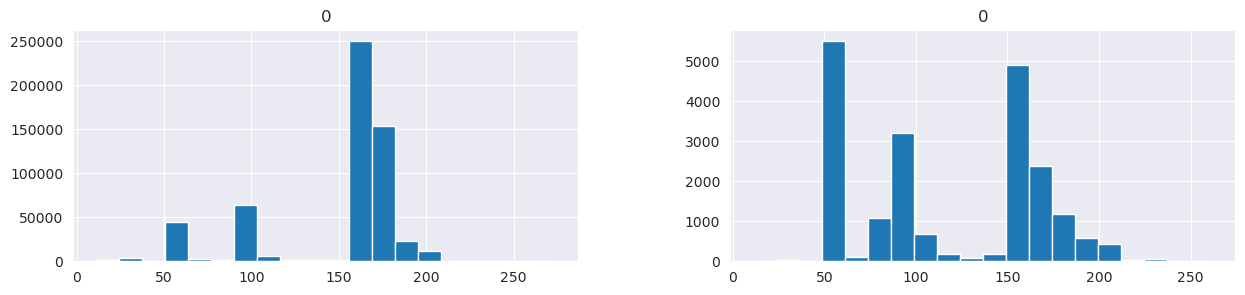

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
train_trn.loc[train_trn['isFraud']==0, vcols].isnull().sum(axis=1).to_frame().hist(ax=ax[0], bins=20)
train_trn.loc[train_trn['isFraud']==1, vcols].isnull().sum(axis=1).to_frame().hist(ax=ax[1], bins=20)

In [108]:
train_trn[vcols].describe().T[['min','max']].T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,1.000,8.000,9.000,6.000,6.000,9.000,9.000,8.000,8.000,4.000,...,55.000,"160,000.000","160,000.000","160,000.000","55,136.000","55,136.000","55,136.000","104,060.000","104,060.000","104,060.000"


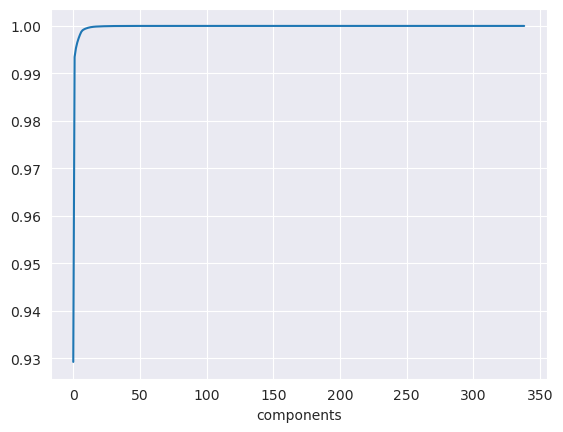

2


In [109]:
vcols = [f'V{i}' for i in range(1,340)]

pca = PCA()
pca.fit(train_trn[vcols].fillna(-1))
plt.xlabel('components')
plt.plot(np.add.accumulate(pca.explained_variance_ratio_))
plt.show()

pca = PCA(n_components=0.99)
vcol_pca = pca.fit_transform(train_trn[vcols].fillna(-1))
print(vcol_pca.ndim)

In [110]:
del train_trn_f0,train_trn_f1,train_id_f0,train_id_f1

print(pd.DataFrame([[val for val in dir()], [sys.getsizeof(eval(val)) for val in dir()]],
                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True)[:10])

           name        size
0     train_trn  1194523747
1      test_trn   798063951
2  train_id_trn   146685065
3      train_id   145098630
4       test_id   141728867
5         vsum0     6838556
6    train_date     4724480
7     test_date     4053688
8           _69     1821899
9            vc     1293475
